# Multivariate time series for energy prediction

In [1]:
# import necessary Python packages
import statsmodels.api as sm
import warnings
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

%matplotlib inline
 
warnings.filterwarnings("ignore")
import pandas as pd
pd.plotting.register_matplotlib_converters()
import numpy as np
np.random.seed(1234)
import seaborn as sns

import plotly.express as px
from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from IPython.display import Image, display

from prophet import Prophet

In [2]:
#pip install Prophet

In [3]:
#edata = pd.read_csv("energydata.csv", index_col="date", parse_dates= [True])

edata = pd.read_csv("energydata.csv")

#d_parser= lambda x: pd.datetime.strptime(x, '%d-%m-%Y %H-%M')
#edata = pd.read_csv("energydata.csv", parse_dates=['date'], date_parser= d_parser)

In [4]:
edata.loc[0,'date']

'11/Jan/2016 17:00'

In [5]:
edata.loc[19734,'date']

'27/May/2016 18:00'

In [6]:
#edata['date']=pd.to_datetime(edata['date'])
#edata.sort_values('date', inplace=True)

#edata['date']=pd.to_datetime(edata['date'], format= '%d-%m-%Y %H-%M')

edata['date']= pd.to_datetime(edata['date'])

In [7]:
print(edata)

                     date  appl  lgt      temp1       rh_1      temp2  \
0     2016-01-11 17:00:00    60   30  19.890000  47.596667  19.200000   
1     2016-01-11 17:10:00    60   30  19.890000  46.693333  19.200000   
2     2016-01-11 17:20:00    50   30  19.890000  46.300000  19.200000   
3     2016-01-11 17:30:00    50   40  19.890000  46.066667  19.200000   
4     2016-01-11 17:40:00    60   40  19.890000  46.333333  19.200000   
...                   ...   ...  ...        ...        ...        ...   
19730 2016-05-27 17:20:00   100    0  25.566667  46.560000  25.890000   
19731 2016-05-27 17:30:00    90    0  25.500000  46.500000  25.754000   
19732 2016-05-27 17:40:00   270   10  25.500000  46.596667  25.628571   
19733 2016-05-27 17:50:00   420   10  25.500000  46.990000  25.414000   
19734 2016-05-27 18:00:00   430   10  25.500000  46.600000  25.264286   

            rh_2      temp3       rh_3      temp4  ...      temp9     rh_9  \
0      44.790000  19.790000  44.730000  19.00

In [8]:
edata.loc[0,'date']

Timestamp('2016-01-11 17:00:00')

In [9]:
#edata['day_name'].value_counts()

In [10]:
edata['date'].min()

Timestamp('2016-01-11 17:00:00')

In [11]:
edata['date'].max()

Timestamp('2016-05-27 18:00:00')

In [12]:
edata['date'].max()-edata['date'].min() # to understand the number of days 

Timedelta('137 days 01:00:00')

In [13]:
edata.size

572315

In [14]:
edata.head()

date  appl  lgt  temp1       rh_1  temp2       rh_2  temp3  \
0 2016-01-11 17:00:00    60   30  19.89  47.596667   19.2  44.790000  19.79   
1 2016-01-11 17:10:00    60   30  19.89  46.693333   19.2  44.722500  19.79   
2 2016-01-11 17:20:00    50   30  19.89  46.300000   19.2  44.626667  19.79   
3 2016-01-11 17:30:00    50   40  19.89  46.066667   19.2  44.590000  19.79   
4 2016-01-11 17:40:00    60   40  19.89  46.333333   19.2  44.530000  19.79   

        rh_3      temp4  ...      temp9   rh_9  temp_out  press  rh_out  \
0  44.730000  19.000000  ...  17.033333  45.53      6.60  733.5    92.0   
1  44.790000  19.000000  ...  17.066667  45.56      6.48  733.6    92.0   
2  44.933333  18.926667  ...  17.000000  45.50      6.37  733.7    92.0   
3  45.000000  18.890000  ...  17.000000  45.40      6.25  733.8    92.0   
4  45.000000  18.890000  ...  17.000000  45.40      6.13  733.9    92.0   

   windspeed  visibility  dewpoint        rv1        rv2  
0   7.000000   63.000000       5.3  13.275433  13.275433  
1   6.666667   59.166667       5.2  18.606195  18.606195  
2   6.333333   55.333333       5.1  28.642668  28.642668  
3   6.000000   51.500000       5.0  45.410390  45.410390  
4   5.666667   47.666667       4.9  10.084097  10.084097  

[5 rows x 29 columns]

In [15]:
edata.tail()

date  appl  lgt      temp1       rh_1      temp2  \
19730 2016-05-27 17:20:00   100    0  25.566667  46.560000  25.890000   
19731 2016-05-27 17:30:00    90    0  25.500000  46.500000  25.754000   
19732 2016-05-27 17:40:00   270   10  25.500000  46.596667  25.628571   
19733 2016-05-27 17:50:00   420   10  25.500000  46.990000  25.414000   
19734 2016-05-27 18:00:00   430   10  25.500000  46.600000  25.264286   

            rh_2      temp3       rh_3  temp4  ...  temp9     rh_9  temp_out  \
19730  42.025714  27.200000  41.163333   24.7  ...   23.2  46.7900      22.7   
19731  42.080000  27.133333  41.223333   24.7  ...   23.2  46.7900      22.6   
19732  42.768571  27.050000  41.690000   24.7  ...   23.2  46.7900      22.5   
19733  43.036000  26.890000  41.290000   24.7  ...   23.2  46.8175      22.3   
19734  42.971429  26.823333  41.156667   24.7  ...   23.2  46.8450      22.2   

       press     rh_out  windspeed  visibility  dewpoint        rv1        rv2  
19730  755.2  55.666667   3.333333   23.666667      13.3  43.096812  43.096812  
19731  755.2  56.000000   3.500000   24.500000      13.3  49.282940  49.282940  
19732  755.2  56.333333   3.666667   25.333333      13.3  29.199117  29.199117  
19733  755.2  56.666667   3.833333   26.166667      13.2   6.322784   6.322784  
19734  755.2  57.000000   4.000000   27.000000      13.2  34.118851  34.118851  

[5 rows x 29 columns]

# Descriptive Statistics 

In [16]:
edata.describe(include='all', datetime_is_numeric= True)

date          appl           lgt         temp1  \
count                19735  19735.000000  19735.000000  19735.000000   
mean   2016-03-20 05:30:00     97.694958      3.801875     21.686571   
min    2016-01-11 17:00:00     10.000000      0.000000     16.790000   
25%    2016-02-14 23:15:00     50.000000      0.000000     20.760000   
50%    2016-03-20 05:30:00     60.000000      0.000000     21.600000   
75%    2016-04-23 11:45:00    100.000000      0.000000     22.600000   
max    2016-05-27 18:00:00   1080.000000     70.000000     26.260000   
std                    NaN    102.524891      7.935988      1.606066   

               rh_1         temp2          rh_2         temp3          rh_3  \
count  19735.000000  19735.000000  19735.000000  19735.000000  19735.000000   
mean      40.259739     20.341219     40.420420     22.267611     39.242500   
min       27.023333     16.100000     20.463333     17.200000     28.766667   
25%       37.333333     18.790000     37.900000     20.790000     36.900000   
50%       39.656667     20.000000     40.500000     22.100000     38.530000   
75%       43.066667     21.500000     43.260000     23.290000     41.760000   
max       63.360000     29.856667     56.026667     29.236000     50.163333   
std        3.979299      2.192974      4.069813      2.006111      3.254576   

              temp4  ...         temp9          rh_9      temp_out  \
count  19735.000000  ...  19735.000000  19735.000000  19735.000000   
mean      20.855335  ...     19.485828     41.552401      7.412580   
min       15.100000  ...     14.890000     29.166667     -5.000000   
25%       19.530000  ...     18.000000     38.500000      3.670000   
50%       20.666667  ...     19.390000     40.900000      6.920000   
75%       22.100000  ...     20.600000     44.338095     10.400000   
max       26.200000  ...     24.500000     53.326667     26.100000   
std        2.042884  ...      2.014712      4.151497      5.318464   

              press        rh_out     windspeed    visibility      dewpoint  \
count  19735.000000  19735.000000  19735.000000  19735.000000  19735.000000   
mean     755.522602     79.750418      4.039752     38.330834      3.760995   
min      729.300000     24.000000      0.000000      1.000000     -6.600000   
25%      750.933333     70.333333      2.000000     29.000000      0.900000   
50%      756.100000     83.666667      3.666667     40.000000      3.430000   
75%      760.933333     91.666667      5.500000     40.000000      6.570000   
max      772.300000    100.000000     14.000000     66.000000     15.500000   
std        7.399441     14.901088      2.451221     11.794719      4.195248   

                rv1           rv2  
count  19735.000000  19735.000000  
mean      24.988033     24.988033  
min        0.005322      0.005322  
25%       12.497889     12.497889  
50%       24.897653     24.897653  
75%       37.583769     37.583769  
max       49.996530     49.996530  
std       14.496634     14.496634  

[8 rows x 29 columns]

In [17]:
#mean_by_weekday=edata.loc['2016', ['appl', 'weekday']].groupby('weekday').mean()
#mean_by_weekday

#daily_mask= edata['day_name'] == 'monday'
#edata[daily_mask].query('appl < 100').sort_values('month')

In [18]:
edata.dtypes

date          datetime64[ns]
appl                   int64
lgt                    int64
temp1                float64
rh_1                 float64
temp2                float64
rh_2                 float64
temp3                float64
rh_3                 float64
temp4                float64
rh_4                 float64
temp5                float64
rh_5                 float64
temp6                float64
rh_6                 float64
temp7                float64
rh_7                 float64
temp8                float64
rh_8                 float64
temp9                float64
rh_9                 float64
temp_out             float64
press                float64
rh_out               float64
windspeed            float64
visibility           float64
dewpoint             float64
rv1                  float64
rv2                  float64
dtype: object

In [19]:
edata.info() # checking for missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        19735 non-null  datetime64[ns]
 1   appl        19735 non-null  int64         
 2   lgt         19735 non-null  int64         
 3   temp1       19735 non-null  float64       
 4   rh_1        19735 non-null  float64       
 5   temp2       19735 non-null  float64       
 6   rh_2        19735 non-null  float64       
 7   temp3       19735 non-null  float64       
 8   rh_3        19735 non-null  float64       
 9   temp4       19735 non-null  float64       
 10  rh_4        19735 non-null  float64       
 11  temp5       19735 non-null  float64       
 12  rh_5        19735 non-null  float64       
 13  temp6       19735 non-null  float64       
 14  rh_6        19735 non-null  float64       
 15  temp7       19735 non-null  float64       
 16  rh_7        19735 non-

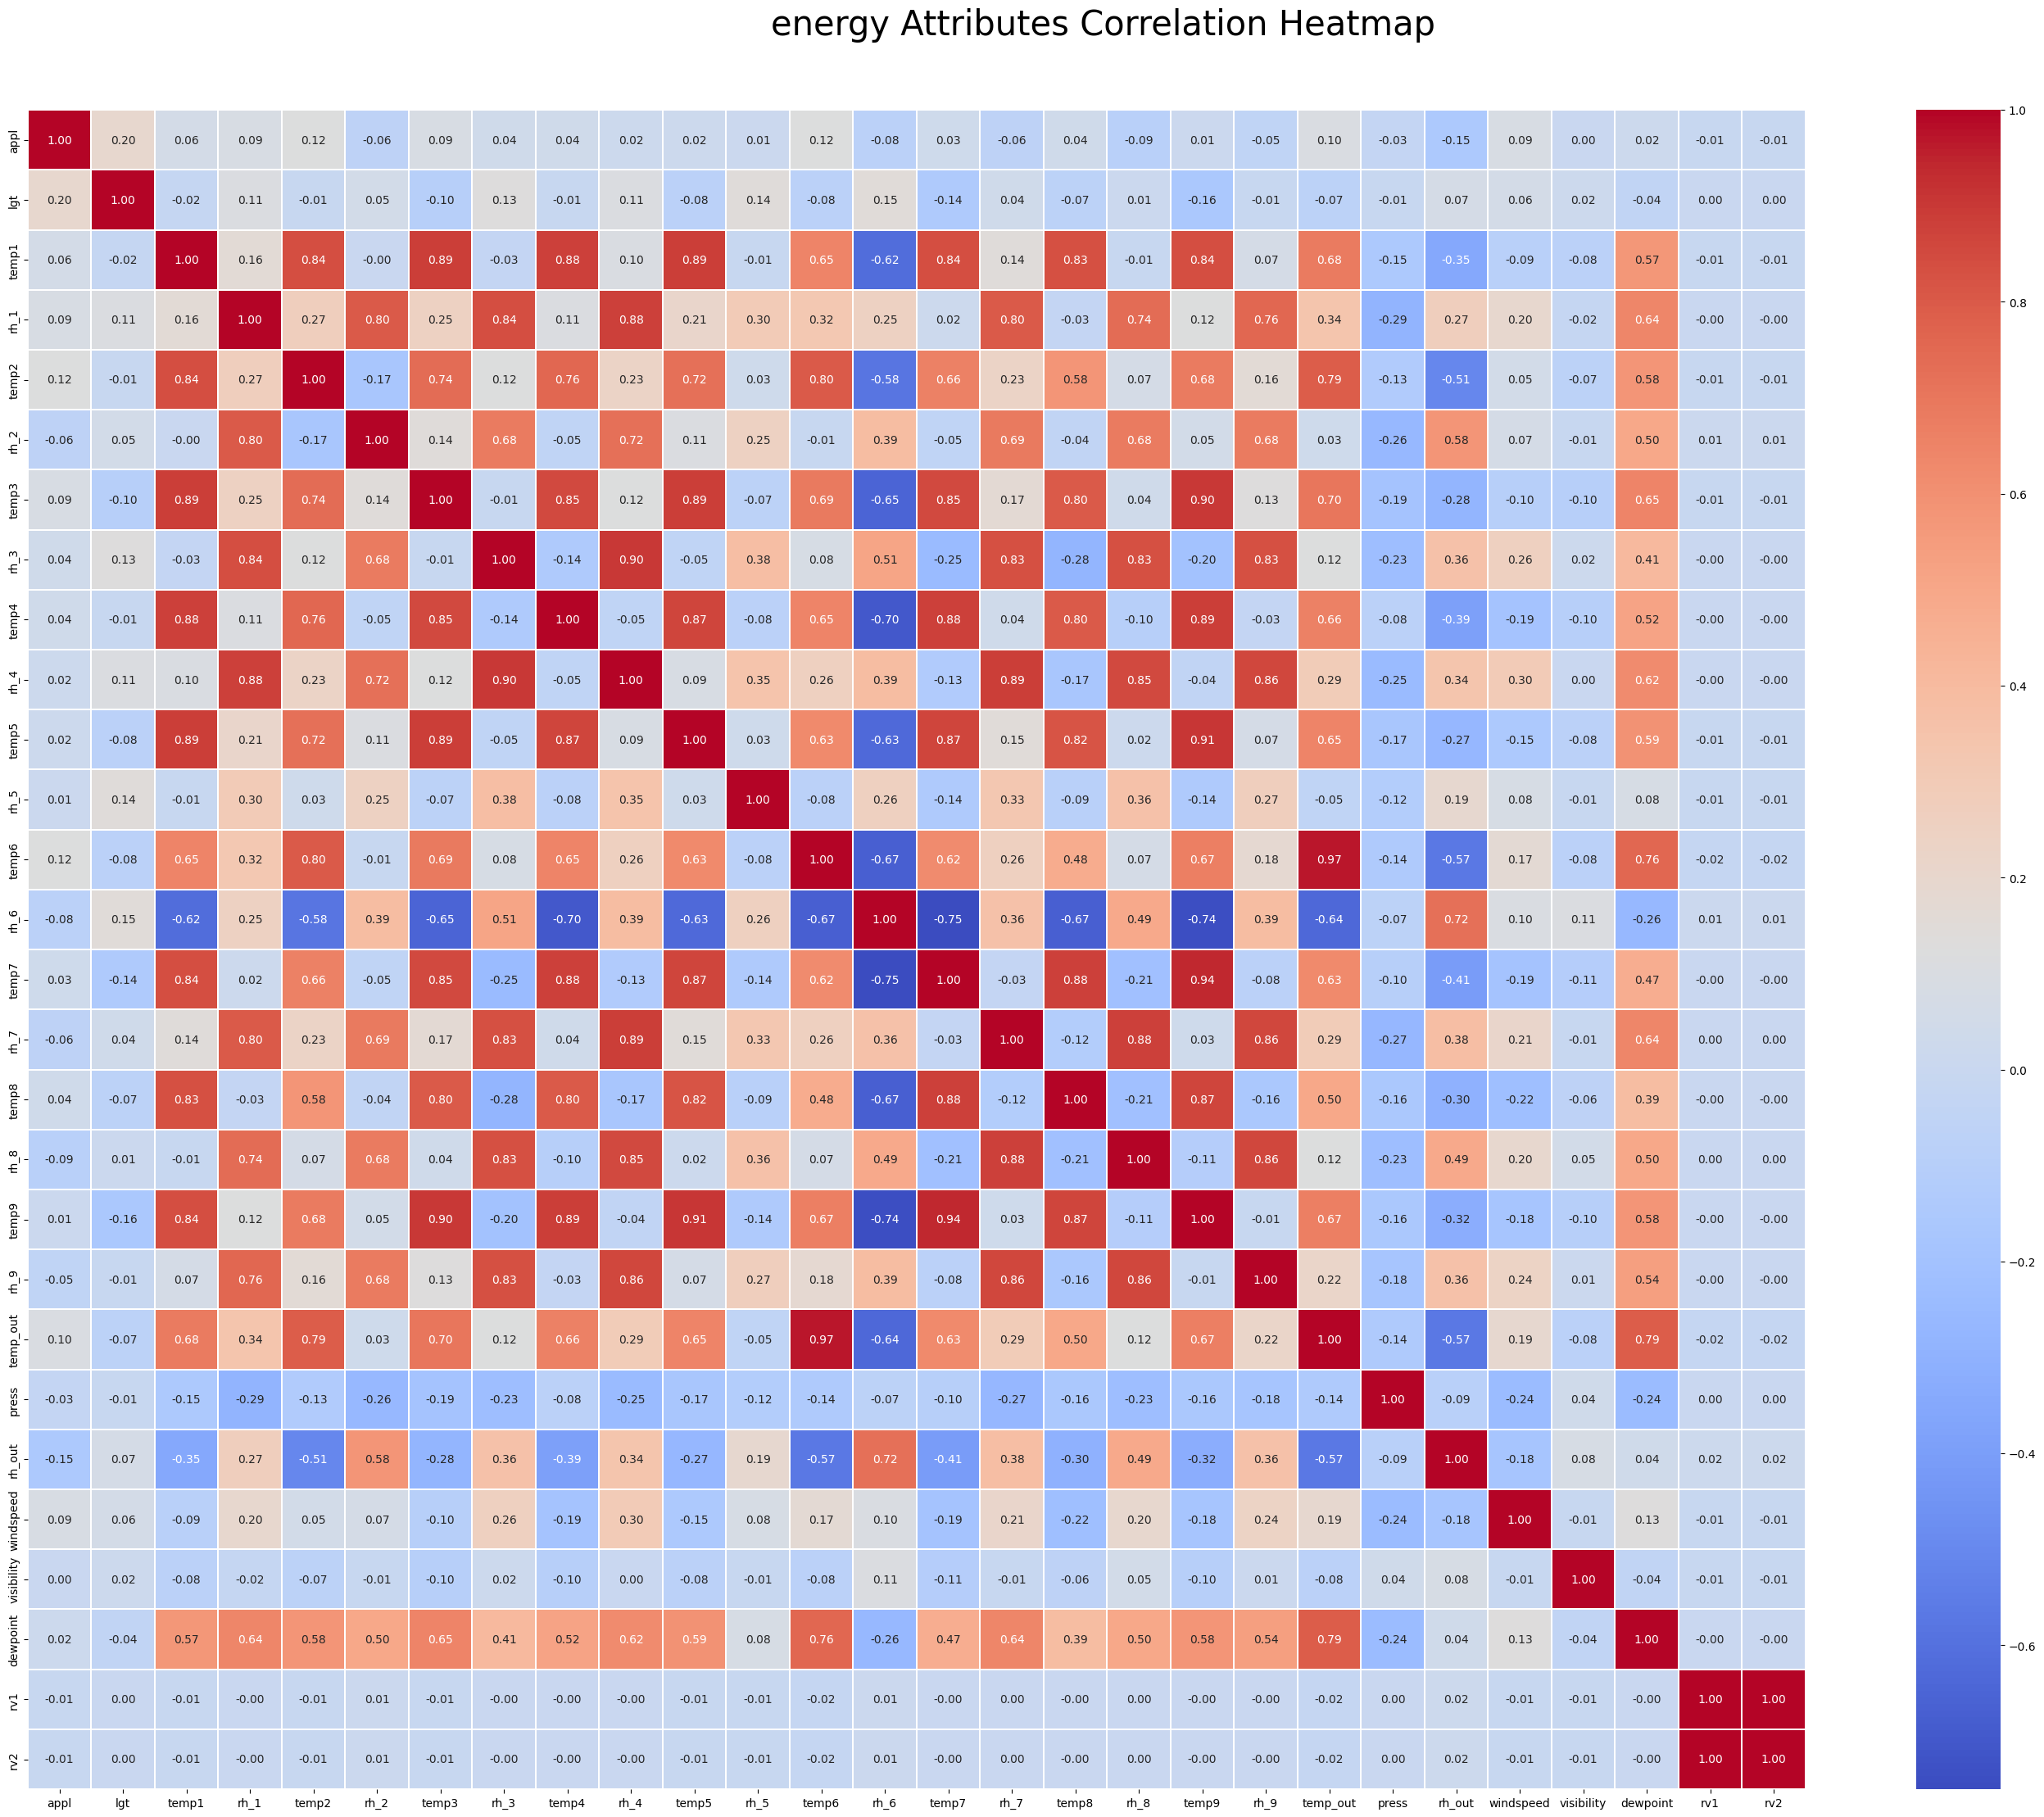

In [20]:
f, ax = plt.subplots(figsize=(35, 25))
corr = edata.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('energy Attributes Correlation Heatmap', fontsize=30)

In [21]:
edata.corr()

appl       lgt     temp1      rh_1     temp2      rh_2  \
appl        1.000000  0.197278  0.055447  0.086031  0.120073 -0.060465   
lgt         0.197278  1.000000 -0.023528  0.106968 -0.005622  0.050985   
temp1       0.055447 -0.023528  1.000000  0.164006  0.836834 -0.002509   
rh_1        0.086031  0.106968  0.164006  1.000000  0.269839  0.797535   
temp2       0.120073 -0.005622  0.836834  0.269839  1.000000 -0.165610   
rh_2       -0.060465  0.050985 -0.002509  0.797535 -0.165610  1.000000   
temp3       0.085060 -0.097393  0.892402  0.253230  0.735245  0.137319   
rh_3        0.036292  0.131161 -0.028550  0.844677  0.121497  0.678326   
temp4       0.040281 -0.008859  0.877001  0.106180  0.762066 -0.047304   
rh_4        0.016965  0.114936  0.097861  0.880359  0.231563  0.721435   
temp5       0.019760 -0.078745  0.885247  0.205797  0.720550  0.110409   
rh_5        0.006955  0.141233 -0.014782  0.303258  0.029595  0.250271   
temp6       0.117638 -0.079029  0.654769  0.316141  0.801186 -0.009670   
rh_6       -0.083178  0.153756 -0.615045  0.245126 -0.580372  0.389933   
temp7       0.025801 -0.135347  0.838705  0.021397  0.663660 -0.051422   
rh_7       -0.055642  0.035069  0.135182  0.801122  0.229212  0.690584   
temp8       0.039572 -0.071458  0.825413 -0.030053  0.578191 -0.041023   
rh_8       -0.094039  0.012915 -0.006441  0.736196  0.068534  0.679777   
temp9       0.010010 -0.157592  0.844777  0.115263  0.675535  0.054544   
rh_9       -0.051462 -0.008766  0.071756  0.764001  0.157346  0.676467   
temp_out    0.099155 -0.074423  0.682854  0.340788  0.792247  0.033703   
press      -0.034885 -0.010576 -0.150574 -0.293957 -0.133028 -0.255646   
rh_out     -0.152282  0.068543 -0.345481  0.274126 -0.505291  0.584911   
windspeed   0.087122  0.060281 -0.087654  0.204932  0.052495  0.069190   
visibility  0.000230  0.020038 -0.076210 -0.021057 -0.069721 -0.005368   
dewpoint    0.015357 -0.036331  0.571333  0.639125  0.582632  0.499154   
rv1        -0.011145  0.000521 -0.006203 -0.000699 -0.011087  0.006275   
rv2        -0.011145  0.000521 -0.006203 -0.000699 -0.011087  0.006275   

               temp3      rh_3     temp4      rh_4  ...     temp9      rh_9  \
appl        0.085060  0.036292  0.040281  0.016965  ...  0.010010 -0.051462   
lgt        -0.097393  0.131161 -0.008859  0.114936  ... -0.157592 -0.008766   
temp1       0.892402 -0.028550  0.877001  0.097861  ...  0.844777  0.071756   
rh_1        0.253230  0.844677  0.106180  0.880359  ...  0.115263  0.764001   
temp2       0.735245  0.121497  0.762066  0.231563  ...  0.675535  0.157346   
rh_2        0.137319  0.678326 -0.047304  0.721435  ...  0.054544  0.676467   
temp3       1.000000 -0.011234  0.852778  0.122737  ...  0.901324  0.134602   
rh_3       -0.011234  1.000000 -0.140457  0.898978  ... -0.195270  0.833538   
temp4       0.852778 -0.140457  1.000000 -0.048650  ...  0.889439 -0.025549   
rh_4        0.122737  0.898978 -0.048650  1.000000  ... -0.044518  0.856591   
temp5       0.888169 -0.050062  0.871813  0.091812  ...  0.911055  0.072308   
rh_5       -0.066355  0.375422 -0.076489  0.352591  ... -0.138509  0.272197   
temp6       0.686882  0.076833  0.652350  0.259047  ...  0.667177  0.184424   
rh_6       -0.647672  0.514912 -0.703149  0.392178  ... -0.738940  0.391943   
temp7       0.847374 -0.250090  0.877763 -0.131204  ...  0.944776 -0.077690   
rh_7        0.172624  0.832685  0.043527  0.894301  ...  0.028055  0.858686   
temp8       0.795283 -0.283228  0.796256 -0.167066  ...  0.869338 -0.156820   
rh_8        0.044427  0.828822 -0.095192  0.847259  ... -0.113014  0.855812   
temp9       0.901324 -0.195270  0.889439 -0.044518  ...  1.000000 -0.008683   
rh_9        0.134602  0.833538 -0.025549  0.856591  ... -0.008683  1.000000   
temp_out    0.699420  0.118237  0.663479  0.293307  ...  0.668218  0.223282   
press      -0.189974 -0.233274 -0.075292 -0.250748  ... -0.156828 -0.183739   
rh_out     -0.281718  0.356192 -0.388602  0.336813  

In [8]:
edata['hour']=edata['date'].dt.hour
edata['dayofweek']=edata['date'].dt.dayofweek
edata['month']=edata['date'].dt.month
edata['year']=edata['date'].dt.year
edata['weekofyear']=edata['date'].dt.weekofyear

In [23]:
edata= edata.set_index('date').resample('H').mean().reset_index() #aggregating into hourly basis

In [9]:
edata.drop(['rv1','rv2'], axis=1, inplace=True)

In [25]:
edata.columns

Index(['date', 'appl', 'lgt', 'temp1', 'rh_1', 'temp2', 'rh_2', 'temp3',
       'rh_3', 'temp4', 'rh_4', 'temp5', 'rh_5', 'temp6', 'rh_6', 'temp7',
       'rh_7', 'temp8', 'rh_8', 'temp9', 'rh_9', 'temp_out', 'press', 'rh_out',
       'windspeed', 'visibility', 'dewpoint', 'hour', 'dayofweek', 'month',
       'year', 'weekofyear'],
      dtype='object')

In [10]:
edata2=edata[['date', 'appl', 'lgt',  'temp1', 'rh_1', 'temp2', 'rh_2', 'temp3',
       'rh_3', 'temp4', 'rh_4', 'temp5', 'rh_5', 'temp6', 'rh_6', 'temp7',
       'rh_7', 'temp8', 'rh_8', 'temp9', 'rh_9', 'temp_out', 'press', 'rh_out',
       'windspeed', 'visibility', 'dewpoint', 'hour', 'dayofweek', 'month',
       'year', 'weekofyear']]

In [11]:
edata2.head()

date  appl  lgt  temp1       rh_1  temp2       rh_2  temp3  \
0 2016-01-11 17:00:00    60   30  19.89  47.596667   19.2  44.790000  19.79   
1 2016-01-11 17:10:00    60   30  19.89  46.693333   19.2  44.722500  19.79   
2 2016-01-11 17:20:00    50   30  19.89  46.300000   19.2  44.626667  19.79   
3 2016-01-11 17:30:00    50   40  19.89  46.066667   19.2  44.590000  19.79   
4 2016-01-11 17:40:00    60   40  19.89  46.333333   19.2  44.530000  19.79   

        rh_3      temp4  ...  press  rh_out  windspeed  visibility  dewpoint  \
0  44.730000  19.000000  ...  733.5    92.0   7.000000   63.000000       5.3   
1  44.790000  19.000000  ...  733.6    92.0   6.666667   59.166667       5.2   
2  44.933333  18.926667  ...  733.7    92.0   6.333333   55.333333       5.1   
3  45.000000  18.890000  ...  733.8    92.0   6.000000   51.500000       5.0   
4  45.000000  18.890000  ...  733.9    92.0   5.666667   47.666667       4.9   

   hour  dayofweek  month  year  weekofyear  
0    17          0      1  2016           2  
1    17          0      1  2016           2  
2    17          0      1  2016           2  
3    17          0      1  2016           2  
4    17          0      1  2016           2  

[5 rows x 32 columns]

In [12]:
edata2.corr()

appl       lgt     temp1      rh_1     temp2      rh_2  \
appl        1.000000  0.197278  0.055447  0.086031  0.120073 -0.060465   
lgt         0.197278  1.000000 -0.023528  0.106968 -0.005622  0.050985   
temp1       0.055447 -0.023528  1.000000  0.164006  0.836834 -0.002509   
rh_1        0.086031  0.106968  0.164006  1.000000  0.269839  0.797535   
temp2       0.120073 -0.005622  0.836834  0.269839  1.000000 -0.165610   
rh_2       -0.060465  0.050985 -0.002509  0.797535 -0.165610  1.000000   
temp3       0.085060 -0.097393  0.892402  0.253230  0.735245  0.137319   
rh_3        0.036292  0.131161 -0.028550  0.844677  0.121497  0.678326   
temp4       0.040281 -0.008859  0.877001  0.106180  0.762066 -0.047304   
rh_4        0.016965  0.114936  0.097861  0.880359  0.231563  0.721435   
temp5       0.019760 -0.078745  0.885247  0.205797  0.720550  0.110409   
rh_5        0.006955  0.141233 -0.014782  0.303258  0.029595  0.250271   
temp6       0.117638 -0.079029  0.654769  0.316141  0.801186 -0.009670   
rh_6       -0.083178  0.153756 -0.615045  0.245126 -0.580372  0.389933   
temp7       0.025801 -0.135347  0.838705  0.021397  0.663660 -0.051422   
rh_7       -0.055642  0.035069  0.135182  0.801122  0.229212  0.690584   
temp8       0.039572 -0.071458  0.825413 -0.030053  0.578191 -0.041023   
rh_8       -0.094039  0.012915 -0.006441  0.736196  0.068534  0.679777   
temp9       0.010010 -0.157592  0.844777  0.115263  0.675535  0.054544   
rh_9       -0.051462 -0.008766  0.071756  0.764001  0.157346  0.676467   
temp_out    0.099155 -0.074423  0.682854  0.340788  0.792247  0.033703   
press      -0.034885 -0.010576 -0.150574 -0.293957 -0.133028 -0.255646   
rh_out     -0.152282  0.068543 -0.345481  0.274126 -0.505291  0.584911   
windspeed   0.087122  0.060281 -0.087654  0.204932  0.052495  0.069190   
visibility  0.000230  0.020038 -0.076210 -0.021057 -0.069721 -0.005368   
dewpoint    0.015357 -0.036331  0.571333  0.639125  0.582632  0.499154   
hour        0.216792  0.255346  0.178858  0.018594  0.254784 -0.183322   
dayofweek   0.003060 -0.099828  0.001381 -0.053782  0.000602 -0.044249   
month      -0.011606 -0.179452  0.706305 -0.094048  0.533479 -0.097914   
year             NaN       NaN       NaN       NaN       NaN       NaN   
weekofyear -0.011356 -0.186486  0.694857 -0.100089  0.512884 -0.089292   

               temp3      rh_3     temp4      rh_4  ...     press    rh_out  \
appl        0.085060  0.036292  0.040281  0.016965  ... -0.034885 -0.152282   
lgt        -0.097393  0.131161 -0.008859  0.114936  ... -0.010576  0.068543   
temp1       0.892402 -0.028550  0.877001  0.097861  ... -0.150574 -0.345481   
rh_1        0.253230  0.844677  0.106180  0.880359  ... -0.293957  0.274126   
temp2       0.735245  0.121497  0.762066  0.231563  ... -0.133028 -0.505291   
rh_2        0.137319  0.678326 -0.047304  0.721435  ... -0.255646  0.584911   
temp3       1.000000 -0.011234  0.852778  0.122737  ... -0.189974 -0.281718   
rh_3       -0.011234  1.000000 -0.140457  0.898978  ... -0.233274  0.356192   
temp4       0.852778 -0.140457  1.000000 -0.048650  ... -0.075292 -0.388602   
rh_4        0.122737  0.898978 -0.048650  1.000000  ... -0.250748  0.336813   
temp5       0.888169 -0.050062  0.871813  0.091812  ... -0.170999 -0.273953   
rh_5       -0.066355  0.375422 -0.076489  0.352591  ... -0.119327  0.185941   
temp6       0.686882  0.076833  0.652350  0.259047  ... -0.141643 -0.569119   
rh_6       -0.647672  0.514912 -0.703149  0.392178  ... -0.065814  0.718587   
temp7       0.847374 -0.250090  0.877763 -0.131204  ... -0.097724 -0.411213   
rh_7        0.172624  0.832685  0.043527  0.894301  ... -0.265850  0.378519   
temp8       0.795283 -0.283228  0.796256 -0.167066  ... -0.162855 -0.300438   
rh_8        0.044427  0.828822 -0.095192  0.847259  ... -0.225591  0.487355   
temp9       0.901324 -0.195270  0.889439 -0.044518  ... -0.156828 -0.318848   
rh_9        0.134602  0.833538 -0.025549  0.856591  ... -0.183739  

## Performing stationary test

In [13]:
from statsmodels.tsa.stattools import adfuller
adfuller(edata2['appl'])

(-21.6163781980362,
 0.0,
 11,
 19723,
 {'1%': -3.430681600227742,
  '5%': -2.8616865555329394,
  '10%': -2.566848007525354},
 220573.74967981718)

<AxesSubplot:title={'center':'appliance energy usage'}, xlabel='date'>

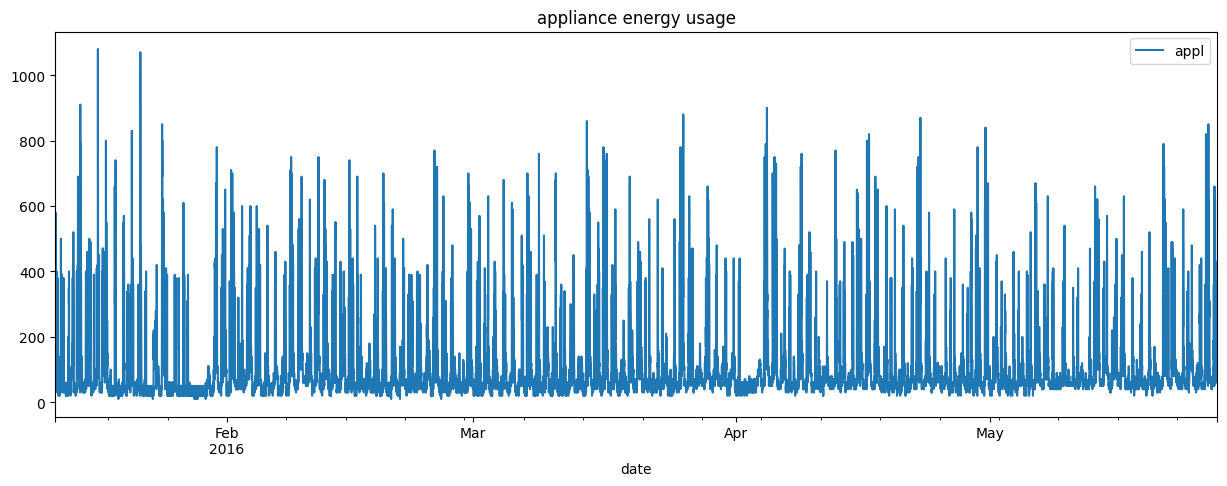

In [14]:
edata2.plot(kind='line', x='date', y='appl', figsize=(15,5), title='appliance energy usage')

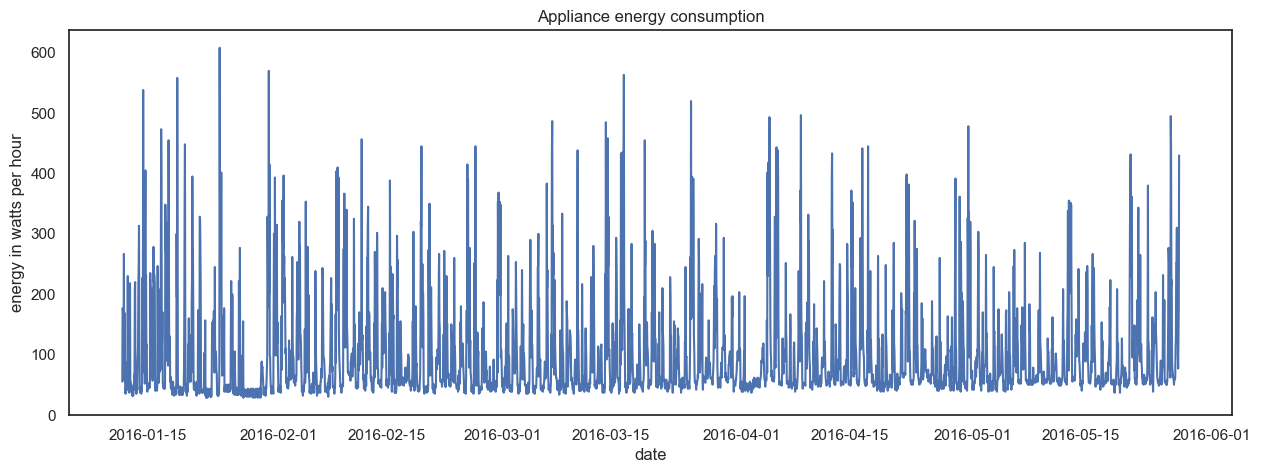

In [31]:
sns.set(rc={'figure.figsize':(15,5)}, style='white')
ax=sns.lineplot(data=edata2, x='date', y='appl')
ax.set_ylabel('energy in watts per hour')
ax.set_title('Appliance energy consumption')
plt.show()

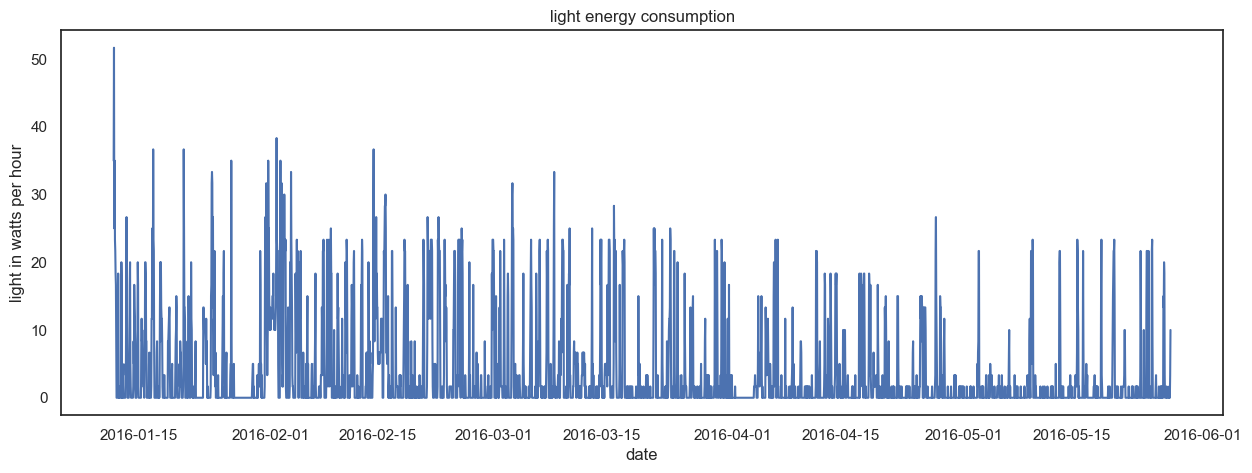

In [32]:
sns.set(rc={'figure.figsize':(15,5)}, style='white')
ax=sns.lineplot(data=edata2, x='date', y='lgt')
ax.set_ylabel('light in watts per hour')
ax.set_title('light energy consumption')
plt.show()

In [33]:
#edata= edata.set_index('date').resample('D').mean().reset_index()

In [15]:
#converting dataframe into index
edata2.set_index('date', inplace=True)

# Time Series Decomposition

### Changing the frequency of the time by resampling technique 

In [35]:
edata2.resample('M').agg({'appl':'sum', 'lgt':'sum', 'temp8':'mean', 'temp_out':'mean','rh_out':'mean'})

appl          lgt      temp8   temp_out     rh_out
date                                                                  
2016-01-31  47251.666667  2300.000000  18.995378   4.129250  86.607461
2016-02-29  70258.333333  4415.000000  21.328102   4.817821  84.230125
2016-03-31  72133.333333  2913.333333  22.127827   5.439646  80.734991
2016-04-30  71200.000000  1740.000000  22.619655   8.514963  77.209954
2016-05-31  60850.000000  1145.000000  24.313614  13.775570  71.384007

In [36]:
#edata["appl_kwH"] = edata["appl"] / 1000 #converting the appliance from wH to kwH

In [37]:
edata2['January 2016']

appl        lgt      temp1       rh_1      temp2  \
date                                                                          
2016-01-11 17:00:00   55.000000  35.000000  19.890000  46.502778  19.200000   
2016-01-11 18:00:00  176.666667  51.666667  19.897778  45.879028  19.268889   
2016-01-11 19:00:00  173.333333  25.000000  20.495556  52.805556  19.925556   
2016-01-11 20:00:00  125.000000  35.000000  20.961111  48.453333  20.251111   
2016-01-11 21:00:00  103.333333  23.333333  21.311667  45.768333  20.587778   
...                         ...        ...        ...        ...        ...   
2016-01-31 19:00:00  118.333333  25.000000  22.685556  47.173333  22.159722   
2016-01-31 20:00:00  153.333333  25.000000  22.858889  46.108889  22.194444   
2016-01-31 21:00:00  100.000000  15.000000  22.963333  46.175278  22.043889   
2016-01-31 22:00:00   70.000000  11.666667  22.787222  46.371667  21.798889   
2016-01-31 23:00:00   38.333333  10.000000  22.433889  46.373889  21.473333   

                          rh_2      temp3       rh_3      temp4       rh_4  \
date                                                                         
2016-01-11 17:00:00  44.626528  19.790000  44.897778  18.932778  45.738750   
2016-01-11 18:00:00  44.438889  19.770000  44.863333  18.908333  46.066667   
2016-01-11 19:00:00  46.061667  20.052222  47.227361  18.969444  47.815556   
2016-01-11 20:00:00  45.632639  20.213889  47.268889  19.190833  49.227917   
2016-01-11 21:00:00  44.961111  20.373333  46.164444  19.425556  47.918889   
...                        ...        ...        ...        ...        ...   
2016-01-31 19:00:00  44.098472  21.735000  46.792778  19.950000  49.895556   
2016-01-31 20:00:00  43.961111  21.886667  46.596667  19.867778  50.469583   
2016-01-31 21:00:00  44.859444  21.890000  46.622083  19.806111  50.536111   
2016-01-31 22:00:00  45.600000  21.834444  46.691111  19.537222  50.056667   
2016-01-31 23:00:00  45.897778  21.707778  46.487778  19.345556  49.798333   

                     ...       press     rh_out  windspeed  visibility  \
date                 ...                                                 
2016-01-11 17:00:00  ...  733.750000  92.000000   6.166667   53.416667   
2016-01-11 18:00:00  ...  734.266667  91.583333   5.416667   40.000000   
2016-01-11 19:00:00  ...  734.791667  89.750000   6.000000   40.000000   
2016-01-11 20:00:00  ...  735.283333  87.583333   6.000000   40.000000   
2016-01-11 21:00:00  ...  735.566667  87.416667   6.000000   40.000000   
...                  ...         ...        ...        ...         ...   
2016-01-31 19:00:00  ...  752.925000  91.416667   7.583333   24.583333   
2016-01-31 20:00:00  ...  753.433333  93.250000   7.416667   39.833333   
2016-01-31 21:00:00  ...  754.066667  94.166667   8.000000   45.333333   
2016-01-31 22:00:00  ...  754.591667  94.250000   8.000000   30.750000   
2016-01-31 23:00:00  ...  755.208333  95.166667   8.000000   36.333333   

                      dewpoint  hour  dayofweek  month    year  weekofyear  
date                                                                        
2016-01-11 17:00:00   5.050000  17.0        0.0    1.0  2016.0         2.0  
2016-01-11 18:00:00   4.658333  18.0        0.0    1.0  2016.0         2.0  
2016-01-11 19:00:00   4.391667  19.0        0.0    1.0  2016.0         2.0  
2016-01-11 20:00:00   4.016667  20.0        0.0    1.0  2016.0         2.0  
2016-01-11 21:00:00   3.816667  21.0        0.0    1.0  2016.0         2.0  
...                        ...   ...        ...    ...     ...         ...  
2016-01-31 19:00:00  10.333333  19.0        6.0    1.0  2016.0         4.0  
2016-01-31 20:00:00  10.583333  20.0        6.0    1.0  2016.0         4.0  
2016-01-31 21:00:00  10.666667  21.0        6.0    1.0  2016.0         4.0  
2016-01-31 22:00:00  10.650000  22.0        6.0    1.0  2016.0         4.0  
2016-01-31 23:00:00  10.616667  23.0        6.0    1.0  2016.0         4.0  

[487 rows x 31 colu

In [38]:
months= ['January 2016', 'February 2016', 'March 2016', 'April 2016', 'May 2016']

### Power consumption distribution histogram and outlier detection

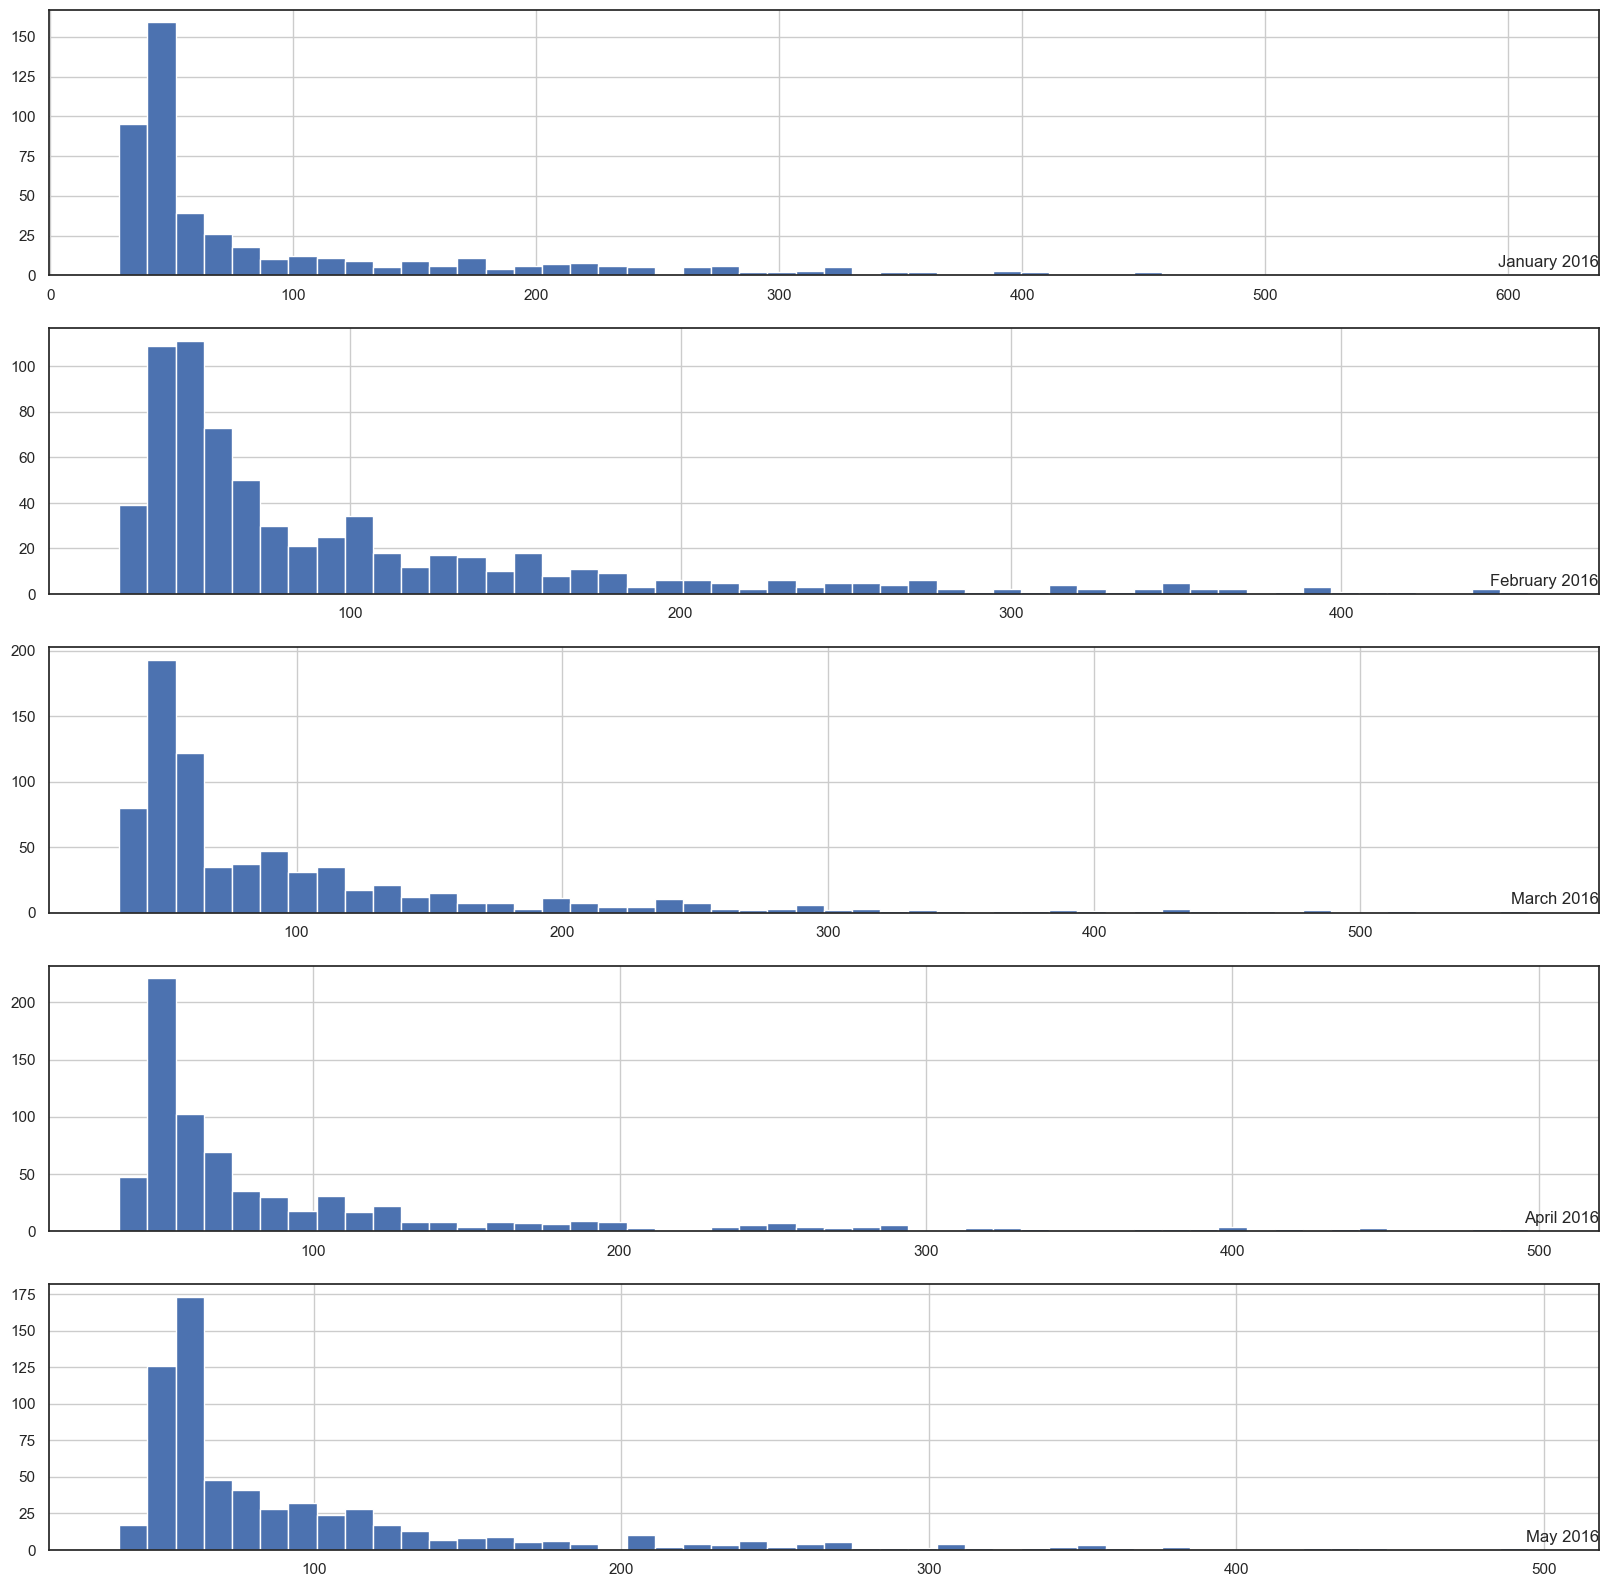

In [39]:
fig, ax= plt.subplots(figsize=(20,20))

for i in range (len(months)):
    plt.subplot(len(months), 1, i+1)
    month= months[i]
    monthly_usage= edata2[str(month)]
    monthly_usage['appl'].hist(bins= 50)
    plt.title(str(month), y=0, loc='right')
plt.show()
fig.tight_layout()

## Observing Trend,seasonlity and Noise

forecasting power for weeks
week1 to week2
week2 to week3
week3 to week4

## Exploring active power consumption for each month

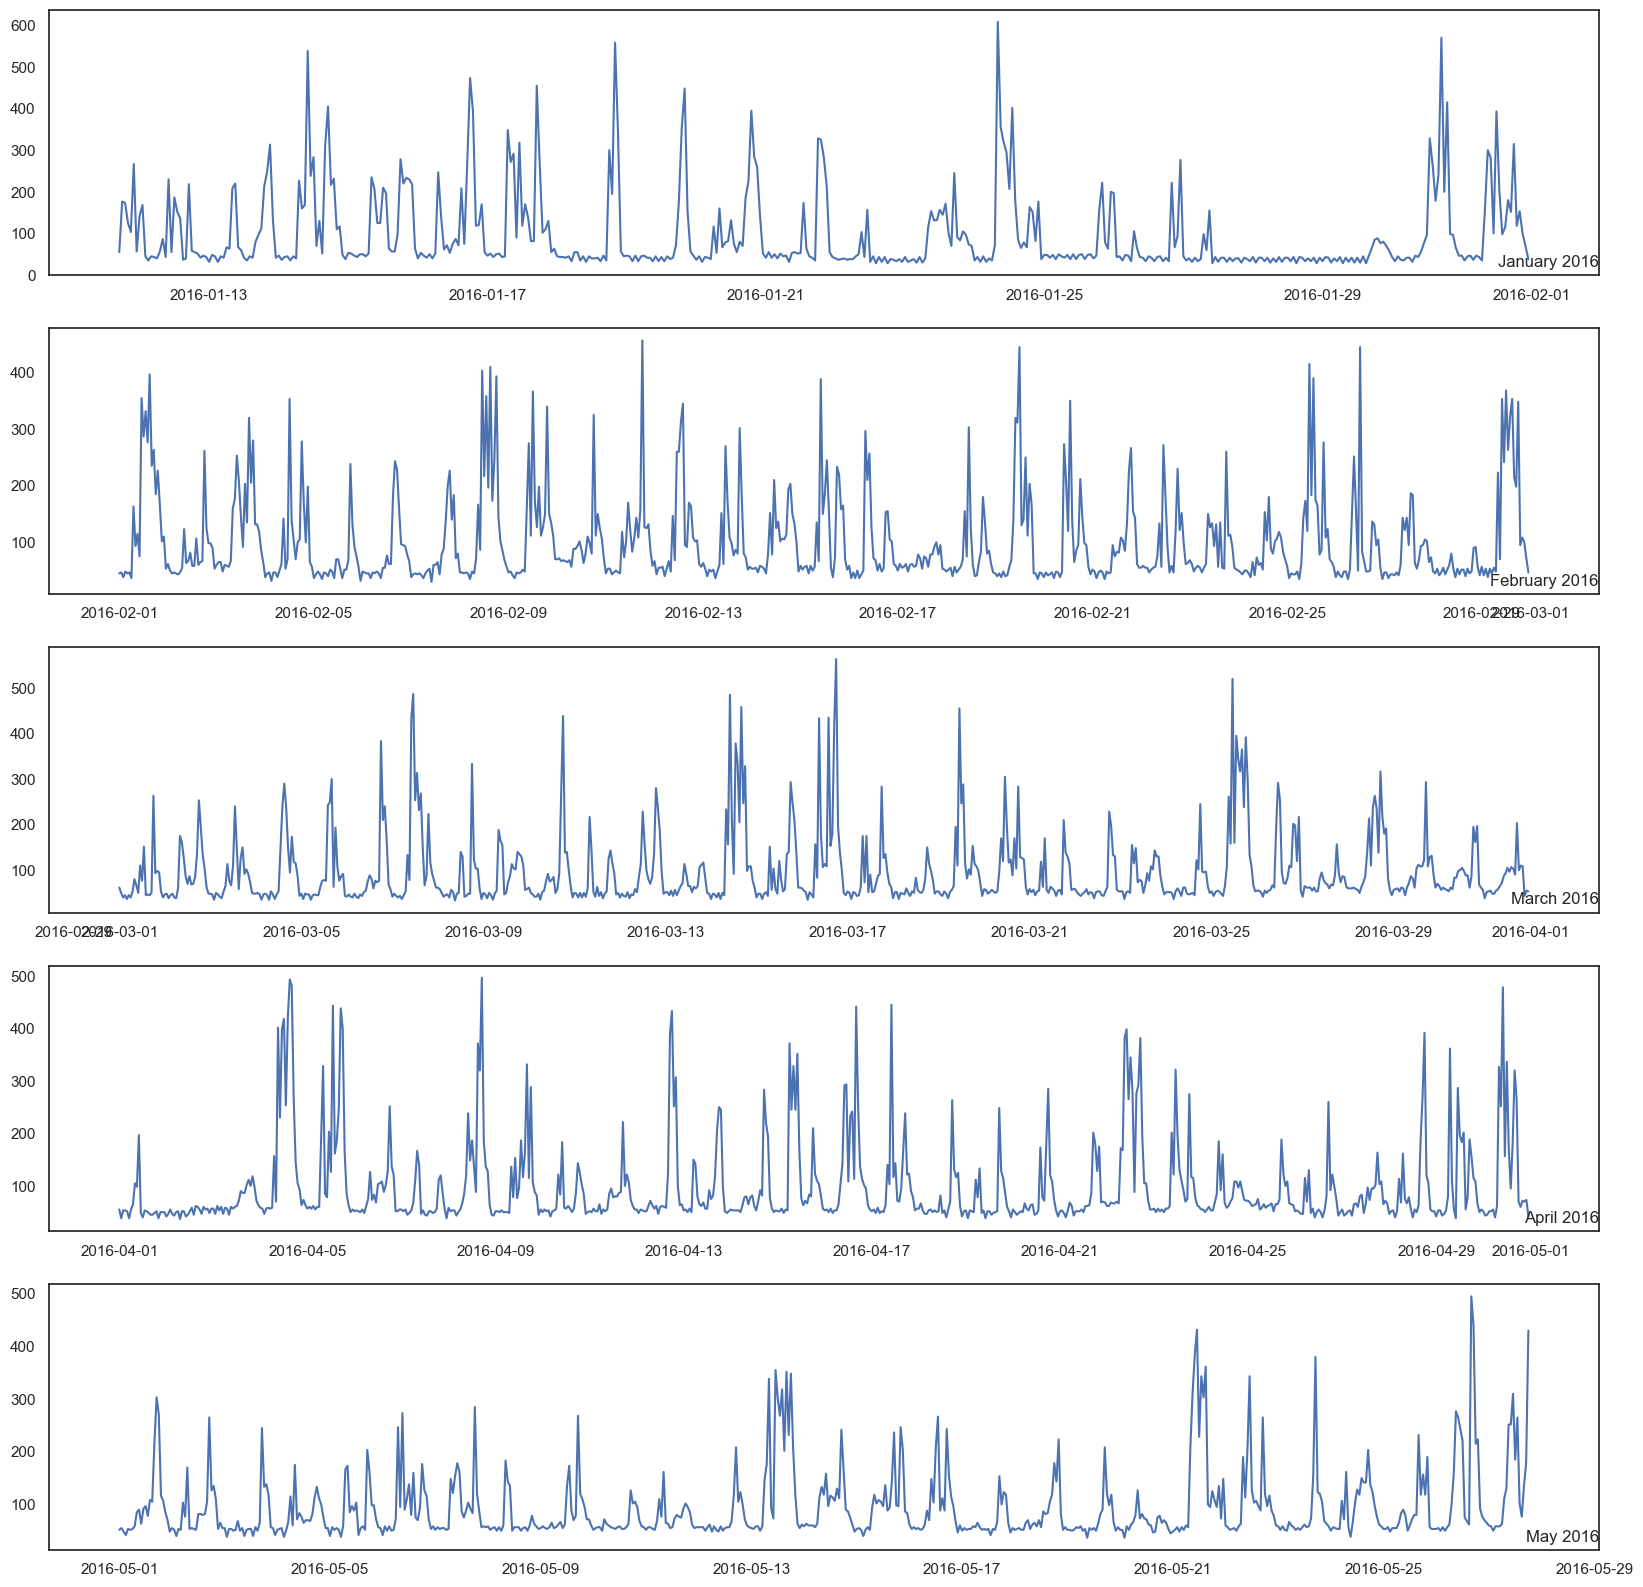

In [40]:
fig, ax=plt.subplots(figsize=(20,20))

for i in range (len(months)):
    plt.subplot(len(months), 1, i+1)
    month= months[i]
    monthly_usage= edata2[str(month)]
    plt.plot(monthly_usage['appl'])
    plt.title(str(month), y=0, loc='right')
plt.show()
fig.tight_layout()

# Decomposing time series

In [17]:
edata_appl = edata2['appl']
decomposition = sm.tsa.seasonal_decompose(edata_appl['2016-01-11':'2016-05-27'], model= 'additive')
 
fig = decomposition.plot()
matplotlib.rcParams['figure.figsize'] = [8.0, 6.0]
plt.savefig('output.png', dpi=300)

ValueError: freq T not understood. Please report if you think this is in error.

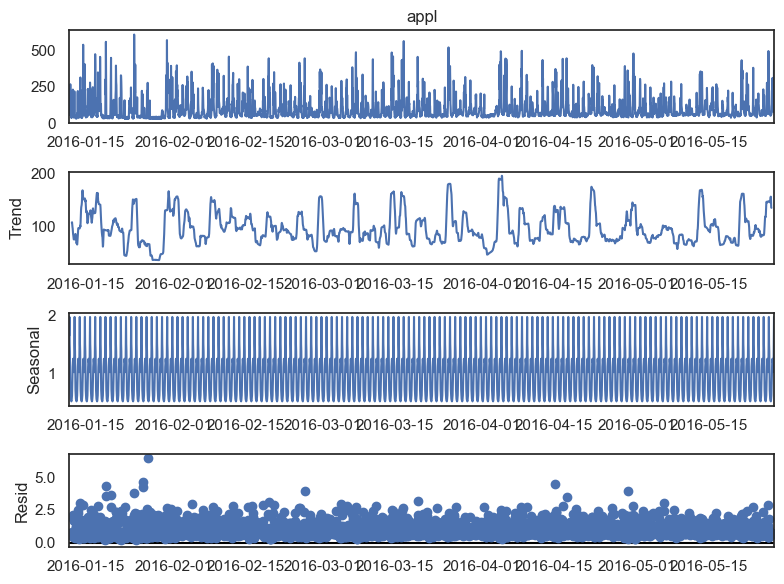

In [42]:
edata_appl2 = edata2['appl']
decomposition = sm.tsa.seasonal_decompose(edata_appl2['2016-01-11':'2016-05-27'], model= 'multiplicative')
 
fig = decomposition.plot()
matplotlib.rcParams['figure.figsize'] = [8.0, 6.0]

## Performing autocorrelation plots

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

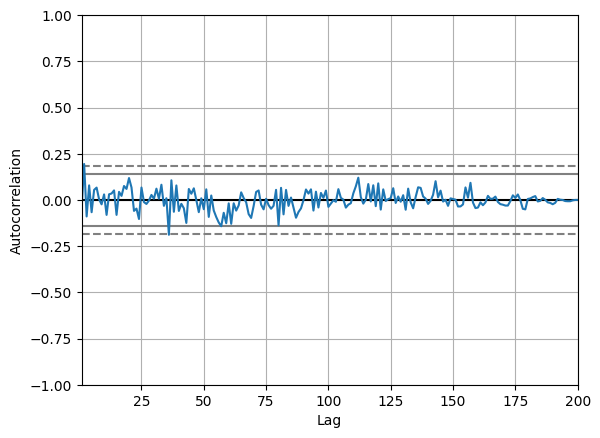

In [18]:
from pandas.plotting import autocorrelation_plot
np.random.seed(0) #will this repeatable
autocorrelation_plot(pd.Series(np.random.random(size=200)))

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

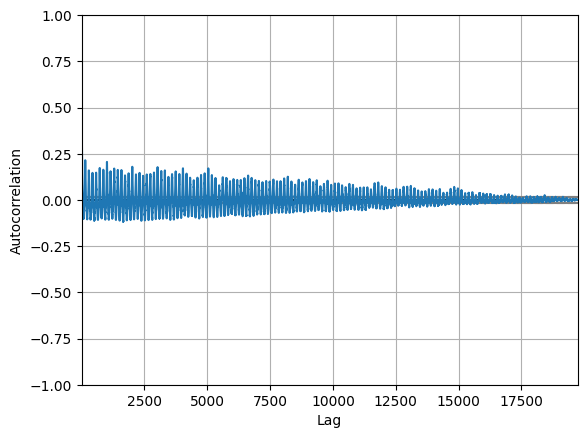

In [19]:
autocorrelation_plot(edata2.appl)

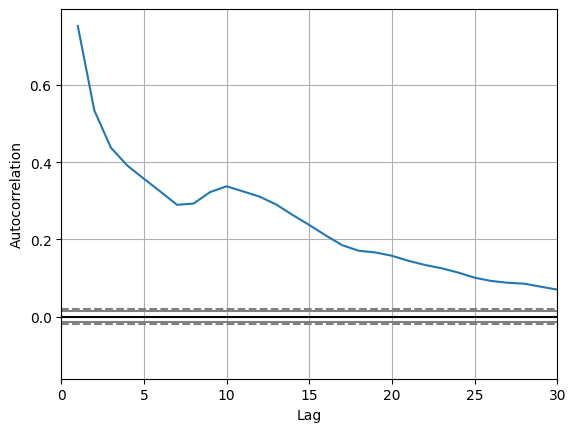

In [20]:
fig, ax=plt.subplots();
autocorrelation_plot(edata2.appl, ax=ax)
ax.set_xlim(0,30); # checking for autocoleration of 30 days interval i.e from monday to monday

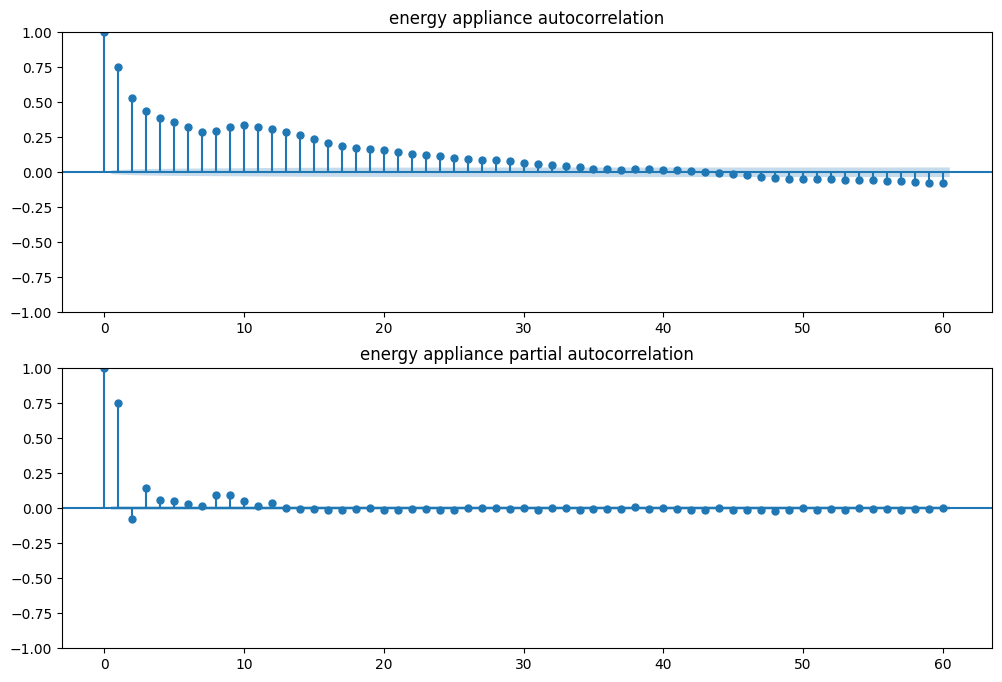

In [21]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(edata2['appl'],lags=60,ax=ax1, title='energy appliance autocorrelation')
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(edata2['appl'],lags=60,ax=ax2, title='energy appliance partial autocorrelation')

## Checking for lag

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

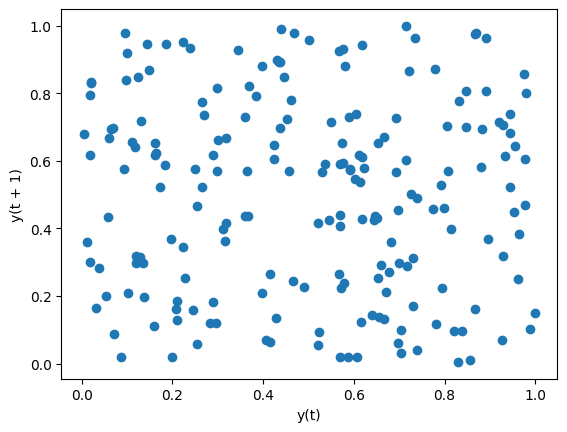

In [22]:
from pandas.plotting import lag_plot
np.random.seed(0) 
lag_plot(pd.Series(np.random.random(size=200)))

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

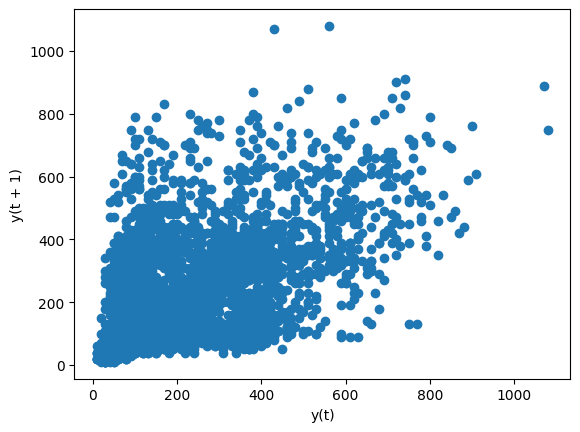

In [23]:
lag_plot(edata2.appl)

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 4)'>

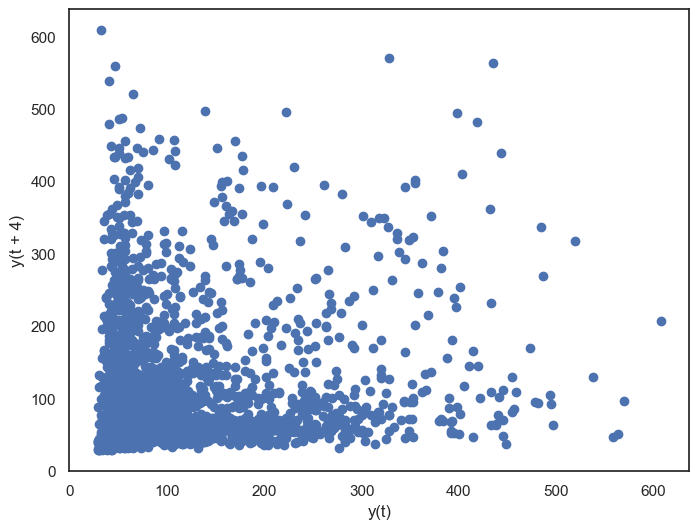

In [49]:
lag_plot(edata2.appl, lag=4)

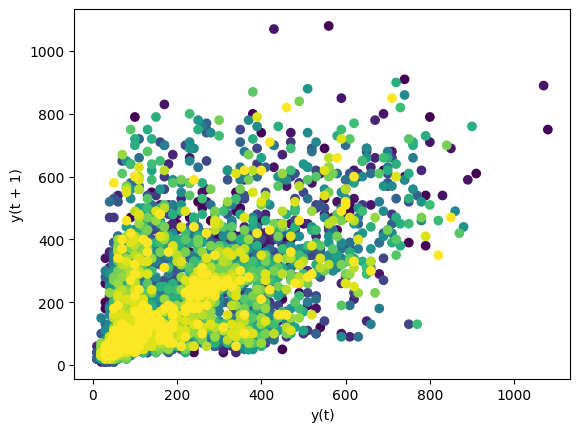

In [24]:
lag_plot(edata2['appl'],c=edata2['weekofyear'][:-1], cmap='viridis');

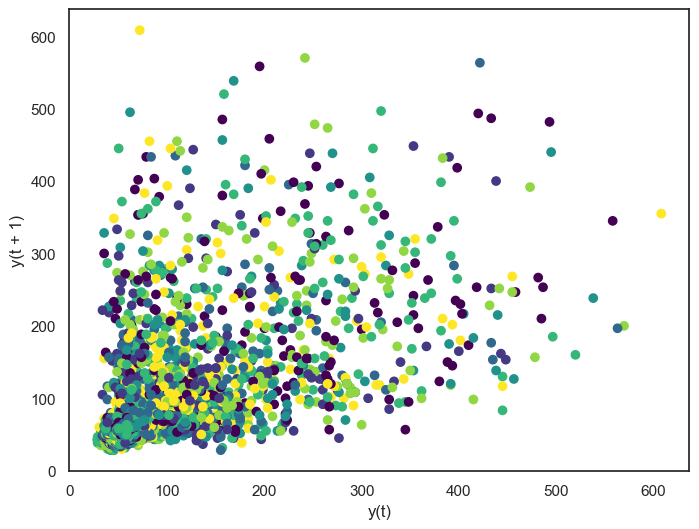

In [51]:
lag_plot(edata2['appl'],c=edata2['dayofweek'][:-1], cmap='viridis');
#where monday=0, sunday=6

## checking for uncertainity within the temperature outside

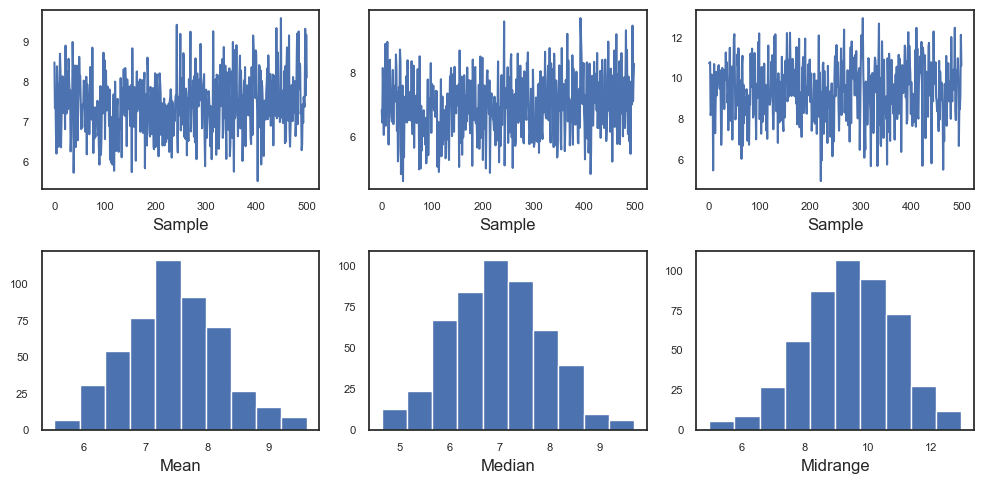

In [52]:
from pandas.plotting import bootstrap_plot
fig= bootstrap_plot(edata2.temp_out, fig=plt.figure(figsize=(10,5)))

## Performing 7 days moving average on the dependent variable

In [25]:
edata3=edata[['date', 'appl', 'lgt',  'temp1', 'rh_1', 'temp2', 'rh_2', 'temp3',
       'rh_3', 'temp4', 'rh_4', 'temp5', 'rh_5', 'temp6', 'rh_6', 'temp7',
       'rh_7', 'temp8', 'rh_8', 'temp9', 'rh_9', 'temp_out', 'press', 'rh_out',
       'windspeed', 'visibility', 'dewpoint', 'hour', 'dayofweek', 'month',
       'year', 'weekofyear']]

In [26]:
edata3= edata3.set_index('date').resample('D').mean().reset_index()

In [27]:
edata3.set_index('date', inplace=True)

Text(0, 0.5, 'Appl(wH)')

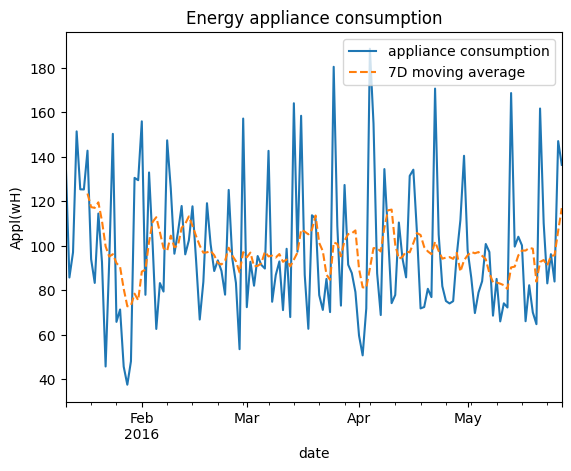

In [28]:
edata3.assign(ma=lambda x: x.appl.rolling(7).mean() #ordinary moving average
            ).plot(y=['appl','ma'],
                  title='Energy appliance consumption',
                  label=['appliance consumption', '7D moving average'],
                  style=['-', '--'])
plt.legend(loc='upper right')
plt.ylabel('Appl(wH)')

<AxesSubplot:xlabel='date'>

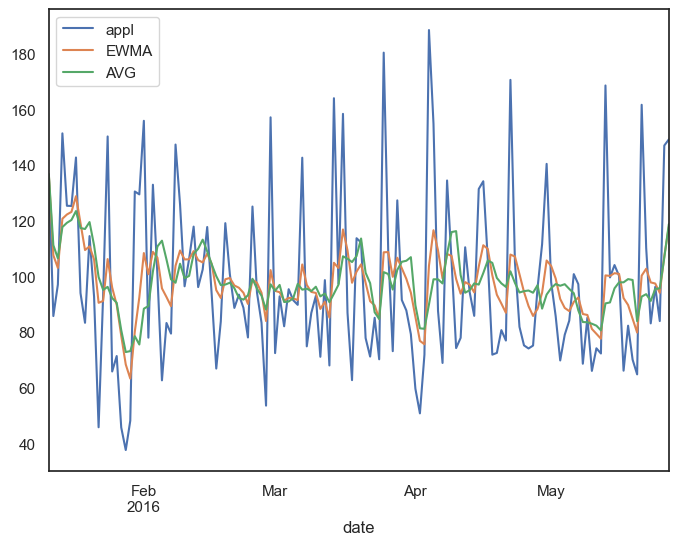

In [57]:
edata3.assign(AVG=lambda x:x.appl.rolling('7D').mean(), #performing exponentially weighted moving windows
            EWMA=lambda x:x.appl.ewm(span= 7).mean()).loc['2016-01-11' : '2016-05-27', ['appl', 'EWMA', 'AVG']].plot()

#edata.assign(AVG=lambda x:x.appl.rolling('7D').mean(), #performing exponentially weighted moving windows
            #EWMA=lambda x:x.appl.ewm(span=7).mean()).loc['2016-01-11' : '2016-05-27', ['appl', 'EWMA', 'AVG']].T

In [58]:
edata.columns

Index(['date', 'appl', 'lgt', 'temp1', 'rh_1', 'temp2', 'rh_2', 'temp3',
       'rh_3', 'temp4', 'rh_4', 'temp5', 'rh_5', 'temp6', 'rh_6', 'temp7',
       'rh_7', 'temp8', 'rh_8', 'temp9', 'rh_9', 'temp_out', 'press', 'rh_out',
       'windspeed', 'visibility', 'dewpoint', 'hour', 'dayofweek', 'month',
       'year', 'weekofyear'],
      dtype='object')

# Forecasting using Facebook Prophet (Multivariate)

In [29]:
ed_fm= edata.reset_index()[['date','appl','lgt','temp1','rh_1','temp2','rh_2','temp3','rh_3','temp4','rh_4','temp5','rh_5','temp6','rh_6','temp7','rh_7','temp8','rh_8','temp9',
                             'rh_9','temp_out','press','rh_out','windspeed','visibility','dewpoint','hour', 'dayofweek', 'month','year', 'weekofyear']].rename({'date':'ds','appl':'y',
                             'lgt':'lgt','temp1':'temp1','rh_1':'rh_1','temp2':'temp2','rh_2':'rh_2','temp3':'temp3','rh_3':'rh_3','temp4':'temp4','rh_4':'rh_4','temp5':'temp5','rh_5':'rh_5',
                             'temp6':'temp6','rh_6':'rh_6','temp7':'temp7','rh_7':'rh_7','temp8':'temp8','rh_8':'rh_8','temp9':'temp9','rh_9':'rh_9','temp_out':'temp_out','press':'press','rh_out':'rh_out',
                             'windspeed':'windspeed','visibility':'visibility','dewpoint':'dewpoint', 'hour':'hour', 'dayofweek':'dayofweek', 'month':'month', 'year':'year', 'weekofyear':'weekofyear' }, axis='columns')

In [30]:
ed_fm.head()

ds   y  lgt  temp1       rh_1  temp2       rh_2  temp3  \
0 2016-01-11 17:00:00  60   30  19.89  47.596667   19.2  44.790000  19.79   
1 2016-01-11 17:10:00  60   30  19.89  46.693333   19.2  44.722500  19.79   
2 2016-01-11 17:20:00  50   30  19.89  46.300000   19.2  44.626667  19.79   
3 2016-01-11 17:30:00  50   40  19.89  46.066667   19.2  44.590000  19.79   
4 2016-01-11 17:40:00  60   40  19.89  46.333333   19.2  44.530000  19.79   

        rh_3      temp4  ...  press  rh_out  windspeed  visibility  dewpoint  \
0  44.730000  19.000000  ...  733.5    92.0   7.000000   63.000000       5.3   
1  44.790000  19.000000  ...  733.6    92.0   6.666667   59.166667       5.2   
2  44.933333  18.926667  ...  733.7    92.0   6.333333   55.333333       5.1   
3  45.000000  18.890000  ...  733.8    92.0   6.000000   51.500000       5.0   
4  45.000000  18.890000  ...  733.9    92.0   5.666667   47.666667       4.9   

   hour  dayofweek  month  year  weekofyear  
0    17          0      1  2016           2  
1    17          0      1  2016           2  
2    17          0      1  2016           2  
3    17          0      1  2016           2  
4    17          0      1  2016           2  

[5 rows x 32 columns]

## Performing feature Selection using Factor Analysis

In [31]:
ed_factor= edata.reset_index()[['date','appl','lgt','temp1','rh_1','temp2','rh_2','temp3','rh_3','temp4','rh_4','temp5','rh_5','temp6','rh_6','temp7','rh_7','temp8','rh_8','temp9',
                             'rh_9','temp_out','press','rh_out','windspeed','visibility','dewpoint','hour', 'dayofweek', 'month','year', 'weekofyear']].rename({'date':'ds','appl':'y',
                             'lgt':'lgt','temp1':'temp1','rh_1':'rh_1','temp2':'temp2','rh_2':'rh_2','temp3':'temp3','rh_3':'rh_3','temp4':'temp4','rh_4':'rh_4','temp5':'temp5','rh_5':'rh_5',
                             'temp6':'temp6','rh_6':'rh_6','temp7':'temp7','rh_7':'rh_7','temp8':'temp8','rh_8':'rh_8','temp9':'temp9','rh_9':'rh_9','temp_out':'temp_out','press':'press','rh_out':'rh_out',
                             'windspeed':'windspeed','visibility':'visibility','dewpoint':'dewpoint', 'hour':'hour', 'dayofweek':'dayofweek', 'month':'month', 'year':'year', 'weekofyear':'weekofyear' }, axis='columns')

In [32]:
ed_factor.shape

(19735, 32)

In [33]:
ed_factor.drop(['ds', 'y', 'year'], axis=1, inplace=True)
#edata_p=edata_p.iloc[0:,1:27]

In [34]:
#pip install factor_analyzer

In [35]:
from factor_analyzer import FactorAnalyzer

In [36]:
#Using Bartlett's test of sphericity
#from factor_analyzer.factor_analyzer import calculate_bartlett_sphericitychi2,p = calculate_bartlett_sphericity(edata_p)
#print("Chi squared value : ",chi2)
#print("p value : ",p)#OUTPUT:Bartlett Sphericity TestChi squared value : 4054.19037041082
#p value : 0.0
#https://www.analyticsvidhya.com/blog/2020/10/dimensionality-reduction-using-factor-analysis-in-python/

In [37]:
from factor_analyzer.factor_analyzer import calculate_kmo

In [38]:
kmo_all, kmo_model = calculate_kmo(ed_factor)

In [39]:
kmo_model#OUTPUT:

0.876568573150226

In [40]:
fa= FactorAnalyzer(n_factors=15, rotation='varimax')

In [41]:
fa.fit(ed_factor)

FactorAnalyzer(n_factors=15, rotation='varimax', rotation_kwargs={})

In [42]:
print(pd.DataFrame(fa.loadings_, index=ed_factor.columns))

                  0         1         2         3         4         5   \
lgt        -0.095893  0.065626 -0.053791  0.448304  0.008547  0.011982   
temp1       0.924912  0.094801  0.072719  0.151488  0.020642  0.165751   
rh_1        0.114141  0.908625  0.039986  0.152657  0.093325 -0.079877   
temp2       0.733269  0.187809  0.332488  0.180230 -0.002181  0.519116   
rh_2        0.032500  0.793853 -0.272861 -0.011045  0.098089 -0.480325   
temp3       0.924046  0.152541  0.059992 -0.029663  0.049688  0.027632   
rh_3       -0.170744  0.919386  0.044642  0.097063  0.060759  0.080609   
temp4       0.924310 -0.010688  0.047147  0.063357 -0.030517  0.126186   
rh_4       -0.025025  0.956064  0.086389  0.119812  0.049383  0.035543   
temp5       0.944332  0.096841  0.015450 -0.008610  0.035518 -0.000634   
rh_5       -0.086177  0.331220 -0.061205  0.189365  0.044381  0.013026   
temp6       0.663655  0.218272  0.564325  0.067027 -0.004734  0.128994   
rh_6       -0.728727  0.411598 -0.3676

In [43]:
fa= FactorAnalyzer(n_factors=10, rotation='varimax')
fa.fit(ed_factor)

FactorAnalyzer(n_factors=10, rotation='varimax', rotation_kwargs={})

In [44]:
print(pd.DataFrame(fa.loadings_, index=ed_factor.columns))

                   0         1         2         3         4         5  \
lgt        -0.090877  0.063326 -0.030691  0.407522  0.019375 -0.031810   
temp1       0.926091  0.089524  0.074015  0.144877  0.022411 -0.133553   
rh_1        0.104968  0.916358  0.011704  0.167646  0.085298  0.044265   
temp2       0.739465  0.179797  0.319226  0.192791 -0.010524 -0.002211   
rh_2        0.022276  0.807727 -0.280792 -0.006918  0.100585  0.027635   
temp3       0.924128  0.153263  0.046324 -0.024321  0.050337  0.004006   
rh_3       -0.171116  0.917048  0.050522  0.092983  0.055754 -0.119397   
temp4       0.929086 -0.013263  0.058880  0.034223 -0.032477  0.002024   
rh_4       -0.025755  0.953842  0.106032  0.119449  0.050868  0.026327   
temp5       0.938604  0.105348 -0.003580  0.014622  0.034506 -0.004217   
rh_5       -0.084237  0.328657 -0.062687  0.184480  0.042644 -0.029923   
temp6       0.665601  0.214593  0.561285  0.086749 -0.021548  0.311685   
rh_6       -0.727227  0.414606 -0.3232

In [45]:
loadings= fa.loadings_

In [46]:
#estimating the eigenvalues and eigenvectors
#ev for eigenvalues
#v for eigenvectors
ev,v=fa.get_eigenvalues()

In [47]:
#performing a sreeplot
xvals= range(1, ed_factor.shape[1]+1)

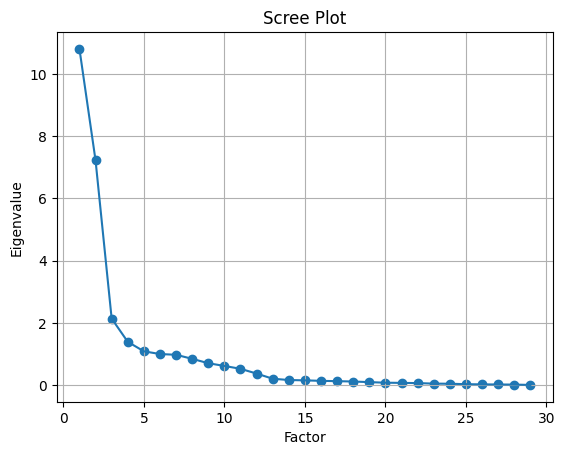

In [48]:
plt.scatter(xvals, ev)
plt.plot(xvals, ev)
plt.title('Scree Plot')
plt.xlabel('Factor')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [49]:
#print(pd.DataFrame.from_records(loadings))

In [50]:
print(pd.DataFrame(fa.get_factor_variance(),index=['Variance','Proportional Var','Cumulative Var']))

                          0         1         2         3         4         5  \
Variance          10.162585  6.990204  1.862881  1.053241  1.034885  0.630384   
Proportional Var   0.350434  0.241042  0.064237  0.036319  0.035686  0.021737   
Cumulative Var     0.350434  0.591475  0.655713  0.692031  0.727717  0.749455   

                         6         7         8         9  
Variance          0.589628  0.450082  0.380549  0.344843  
Proportional Var  0.020332  0.015520  0.013122  0.011891  
Cumulative Var    0.769786  0.785307  0.798429  0.810320  


In [51]:
print(pd.DataFrame(fa.get_communalities(),index=ed_factor.columns,columns=['Communalities']))

            Communalities
lgt              0.258919
temp1            0.943476
rh_1             0.946912
temp2            0.996299
rh_2             0.954940
temp3            0.891098
rh_3             0.922948
temp4            0.921577
rh_4             0.944885
temp5            0.913963
rh_5             0.396265
temp6            0.963061
rh_6             0.912950
temp7            0.920709
rh_7             0.889837
temp8            0.877805
rh_8             0.917057
temp9            0.971034
rh_9             0.886426
temp_out         0.987274
press            0.995331
rh_out           0.993212
windspeed        0.349022
visibility       0.024011
dewpoint         0.987875
hour             0.628658
dayofweek        0.168516
month            0.958449
weekofyear       0.976772


In [52]:
ed_fs=ed_fm[['ds', 'y', 'temp9','rh_4','hour','temp6','dewpoint','rh_5', 'dayofweek', 'temp_out', 'visibility']] 
ed_fs.head()

ds   y      temp9       rh_4  hour     temp6  dewpoint  \
0 2016-01-11 17:00:00  60  17.033333  45.566667    17  7.026667       5.3   
1 2016-01-11 17:10:00  60  17.066667  45.992500    17  6.833333       5.2   
2 2016-01-11 17:20:00  50  17.000000  45.890000    17  6.560000       5.1   
3 2016-01-11 17:30:00  50  17.000000  45.723333    17  6.433333       5.0   
4 2016-01-11 17:40:00  60  17.000000  45.530000    17  6.366667       4.9   

    rh_5  dayofweek  temp_out  visibility  
0  55.20          0      6.60   63.000000  
1  55.20          0      6.48   59.166667  
2  55.09          0      6.37   55.333333  
3  55.09          0      6.25   51.500000  
4  55.09          0      6.13   47.666667

In [86]:
#ed_fs= ed_fs.set_index('ds').resample('D').mean().reset_index()

In [53]:
ed_fs.shape

(19735, 11)

In [54]:
ed_fs.head()

ds   y      temp9       rh_4  hour     temp6  dewpoint  \
0 2016-01-11 17:00:00  60  17.033333  45.566667    17  7.026667       5.3   
1 2016-01-11 17:10:00  60  17.066667  45.992500    17  6.833333       5.2   
2 2016-01-11 17:20:00  50  17.000000  45.890000    17  6.560000       5.1   
3 2016-01-11 17:30:00  50  17.000000  45.723333    17  6.433333       5.0   
4 2016-01-11 17:40:00  60  17.000000  45.530000    17  6.366667       4.9   

    rh_5  dayofweek  temp_out  visibility  
0  55.20          0      6.60   63.000000  
1  55.20          0      6.48   59.166667  
2  55.09          0      6.37   55.333333  
3  55.09          0      6.25   51.500000  
4  55.09          0      6.13   47.666667

In [55]:
#edata_final['y_origi']= np.log(edata_final['y'])
e_train= ed_fs[(ed_fs['ds'] >= '2016-01-11') & (ed_fs['ds'] <= '2016-04-16')]
e_test= ed_fs[(ed_fs['ds'] >'2016-04-16')]


In [56]:
e_train.shape

(13723, 11)

In [57]:
e_test.shape

(6012, 11)

In [58]:
e_train

ds   y      temp9       rh_4  hour      temp6  \
0     2016-01-11 17:00:00  60  17.033333  45.566667    17   7.026667   
1     2016-01-11 17:10:00  60  17.066667  45.992500    17   6.833333   
2     2016-01-11 17:20:00  50  17.000000  45.890000    17   6.560000   
3     2016-01-11 17:30:00  50  17.000000  45.723333    17   6.433333   
4     2016-01-11 17:40:00  60  17.000000  45.530000    17   6.366667   
...                   ...  ..        ...        ...   ...        ...   
13718 2016-04-15 23:20:00  60  20.856667  40.500000    23  10.500000   
13719 2016-04-15 23:30:00  60  20.815000  40.437778    23  10.566667   
13720 2016-04-15 23:40:00  70  20.823333  40.340000    23  10.566667   
13721 2016-04-15 23:50:00  50  20.856667  40.230000    23  10.500000   
13722 2016-04-16 00:00:00  70  20.790000  40.200000     0  10.390000   

       dewpoint       rh_5  dayofweek  temp_out  visibility  
0          5.30  55.200000          0      6.60   63.000000  
1          5.20  55.200000          0      6.48   59.166667  
2          5.10  55.090000          0      6.37   55.333333  
3          5.00  55.090000          0      6.25   51.500000  
4          4.90  55.090000          0      6.13   47.666667  
...         ...        ...        ...       ...         ...  
13718      7.53  53.466667          4     10.70   40.000000  
13719      7.55  53.326667          4     10.80   40.000000  
13720      7.57  53.260000          4     10.80   40.000000  
13721      7.58  53.200000          4     10.90   40.000000  
13722      7.60  53.090000          5     10.90   40.000000  

[13723 rows x 11 columns]

In [59]:
m= Prophet(interval_width=0.95, changepoint_prior_scale=0.5)
#m= Prophet(interval_width=0.95, changepoint_prior_scale=0.5, weekly_seasonality=True, yearly_seasonality=False, daily_seasonality=True)
#m.add_seasonality(name='weekly', period=7, fourier_order=3)
#m= Prophet()

In [60]:
e_train.columns

Index(['ds', 'y', 'temp9', 'rh_4', 'hour', 'temp6', 'dewpoint', 'rh_5',
       'dayofweek', 'temp_out', 'visibility'],
      dtype='object')

In [61]:
#m.add_regressor('year', standardize=False)
m.add_regressor('temp9')
m.add_regressor('rh_4')   
m.add_regressor('temp6')
m.add_regressor('dewpoint')
m.add_regressor('rh_5')
m.add_regressor('dayofweek', standardize=False)
m.add_regressor('hour', standardize=False)
m.add_regressor('temp_out')
m.add_regressor('visibility')
#m.add_regressor('weekofyear', standardize=False)
#m.add_regressor('month_temp', standardize=False)
#m.add_regressor('month_bins', standardize=False, mode='multiplicative')


In [62]:
m.fit(e_train)

20:07:54 - cmdstanpy - INFO - Chain [1] start processing
20:08:11 - cmdstanpy - INFO - Chain [1] done processing


In [63]:
m.params # printing parameters

OrderedDict([('lp__', array([[26201.9]])),
             ('k', array([[0.522498]])),
             ('m', array([[0.0805794]])),
             ('delta',
              array([[-0.750387  , -0.287295  , -0.0064147 ,  0.0420255 ,  1.16713   ,
                       0.198723  , -0.933087  ,  0.251957  , -0.0600289 , -0.383869  ,
                      -0.00992705,  0.298197  , -0.0818507 ,  0.191043  , -0.105569  ,
                      -0.0824229 , -0.105769  ,  0.172274  ,  0.498956  ,  0.130936  ,
                      -1.06146   ,  0.00558645,  0.641293  , -0.267462  ,  0.099854  ]])),
             ('sigma_obs', array([[0.0896822]])),
             ('beta',
              array([[ 3.71024e-05, -9.20495e-03,  3.37275e-03, -2.92490e-04,
                      -1.38206e-03,  3.80639e-03, -3.86380e-02, -3.05161e-02,
                      -1.31645e-02, -7.68576e-03,  1.57686e-02, -1.25630e-02,
                       7.45816e-03,  4.09345e-03, -1.07934e-02,  7.20964e-03,
                      -2.227

In [71]:
future = m.make_future_dataframe(periods= 1002, freq='H') # 
future.tail()

ValueError: Invalid frequency: 1hr10min

In [65]:
future['temp9']= ed_fs['temp9']
future['rh_4']= ed_fs['rh_4']
future['temp6']= ed_fs['temp6']
future['hour']= ed_fs['hour']
future['dewpoint']= ed_fs['dewpoint']
future['rh_5']= ed_fs['rh_5']
future['dayofweek']= ed_fs['dayofweek']
future['temp_out']= ed_fs['temp_out']
future['visibility']= ed_fs['visibility']

In [66]:
future

ds      temp9       rh_4      temp6  hour  dewpoint  \
0     2016-01-11 17:00:00  17.033333  45.566667   7.026667    17      5.30   
1     2016-01-11 17:10:00  17.066667  45.992500   6.833333    17      5.20   
2     2016-01-11 17:20:00  17.000000  45.890000   6.560000    17      5.10   
3     2016-01-11 17:30:00  17.000000  45.723333   6.433333    17      5.00   
4     2016-01-11 17:40:00  17.000000  45.530000   6.366667    17      4.90   
...                   ...        ...        ...        ...   ...       ...   
14720 2016-05-27 14:00:00  20.323333  35.290000  10.330000    22      5.47   
14721 2016-05-27 15:00:00  20.390000  35.290000  10.245000    22      5.45   
14722 2016-05-27 16:00:00  20.390000  35.277143  10.066667    22      5.43   
14723 2016-05-27 17:00:00  20.390000  35.254000  10.000000    22      5.42   
14724 2016-05-27 18:00:00  20.390000  35.290000   9.890000    23      5.40   

            rh_5  dayofweek  temp_out  visibility  
0      55.200000          0      6.60   63.000000  
1      55.200000          0      6.48   59.166667  
2      55.090000          0      6.37   55.333333  
3      55.090000          0      6.25   51.500000  
4      55.090000          0      6.13   47.666667  
...          ...        ...       ...         ...  
14720  71.060000          4     10.50   36.333333  
14721  68.996667          4     10.40   34.500000  
14722  67.523333          4     10.20   32.666667  
14723  65.960000          4     10.10   30.833333  
14724  64.595000          4     10.00   29.000000  

[14725 rows x 10 columns]

In [67]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower   yhat_upper
14720 2016-05-27 14:00:00  169.851056 -600.304854  1008.504304
14721 2016-05-27 15:00:00  161.133792 -631.517272   982.416296
14722 2016-05-27 16:00:00  170.587571 -604.153091  1031.352774
14723 2016-05-27 17:00:00  195.559404 -568.229265  1035.472840
14724 2016-05-27 18:00:00  221.083760 -555.592813  1086.127832

In [68]:
from sklearn.metrics import r2_score
print('r2:', r2_score(ed_fs['y'], forecast['yhat']))

ValueError: Found input variables with inconsistent numbers of samples: [19735, 14725]

In [103]:
forecast

ds       trend  yhat_lower  yhat_upper  trend_lower  \
0    2016-01-11 17:00:00  112.947425   52.514749  342.824138   112.947425   
1    2016-01-11 18:00:00  112.892394   78.093383  355.117836   112.892394   
2    2016-01-11 19:00:00  112.837363   72.796134  357.197541   112.837363   
3    2016-01-11 20:00:00  112.782332   48.920518  329.010160   112.782332   
4    2016-01-11 21:00:00  112.727300    8.143637  281.157780   112.727300   
...                  ...         ...         ...         ...          ...   
3285 2016-05-27 14:00:00  139.733621  -57.755562  312.313579    27.391905   
3286 2016-05-27 15:00:00  139.755358  -57.278676  312.469106    27.344750   
3287 2016-05-27 16:00:00  139.777094  -45.839970  336.376550    27.297594   
3288 2016-05-27 17:00:00  139.798831  -15.564313  364.767366    27.250439   
3289 2016-05-27 18:00:00  139.820567    7.453072  380.637416    27.203283   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0      112.947425       86.413865             86.413865             86.413865   
1      112.892394      103.683076            103.683076            103.683076   
2      112.837363       99.503995             99.503995             99.503995   
3      112.782332       75.364511             75.364511             75.364511   
4      112.727300       29.695481             29.695481             29.695481   
...           ...             ...                   ...                   ...   
3285   265.198440      -12.249048            -12.249048            -12.249048   
3286   265.469633      -14.465471            -14.465471            -14.465471   
3287   265.740826        2.081308              2.081308              2.081308   
3288   266.012019       30.504817             30.504817             30.504817   
3289   266.283212       51.208721             51.208721             51.208721   

          daily  ...  visibility  visibility_lower  visibility_upper  \
0     58.376828  ...    1.153168          1.153168          1.153168   
1     75.762016  ...    0.084978          0.084978          0.084978   
2     68.786985  ...    0.084978          0.084978          0.084978   
3     36.890263  ...    0.084978          0.084978          0.084978   
4     -4.746861  ...    0.084978          0.084978          0.084978   
...         ...  ...         ...               ...               ...   
3285  17.368723  ...   -1.381295         -1.381295         -1.381295   
3286  15.943061  ...   -1.361390         -1.361390         -1.361390   
3287  32.269900  ...   -1.301678         -1.301678         -1.301678   
3288  58.376828  ...   -1.182253         -1.182253         -1.182253   
3289  75.762016  ...   -0.950038         -0.950038         -0.950038   

        weekly  weekly_lower  weekly_upper  multiplicative_terms  \
0     9.435859      9.435859      9.435859                   0.0   
1     8.610017      8.610017      8.610017                   0.0   
2     7.722070      7.722070      7.722070                   0.0   
3     6.777346      6.777346      6.777346                   0.0   
4     5.781770      5.781770      5.781770                   0.0   
...        ...           ...           ...                   ...   
3285  0.701701      0.701701      0.701701                   0.0   
3286  1.354492      1.354492      1.354492                   0.0   
3287  2.002993      2.002993      2.002993                   0.0   
3288  2.641900      2.641900      2.641900                   0.0   
3289  3.266011      3.266011      3.266011                   0.0   

      multiplicative_terms_lower  multiplicative_terms_upper        yhat  
0                            0.0                         0.0  199.361290  
1                            0.0                         0.0  216.575470  
2                            0.0                         0.0  212.341358  
3                            0.0                         0.0  188.146843  
4                            0.0                         0.0  142.4

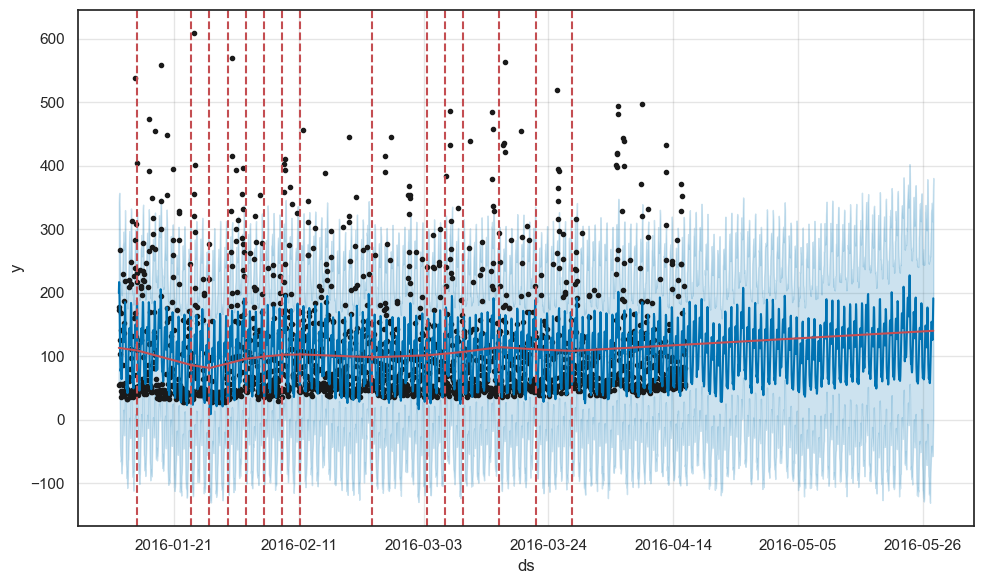

In [104]:
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [105]:
print(m.params['delta'])

[[-1.90169e-01 -1.93574e-06  8.30022e-06  1.64005e-01  5.90277e-01
   3.50670e-02 -2.06765e-01 -4.85499e-02 -1.02149e-01 -9.44036e-02
   2.82112e-07  5.02295e-07  2.71150e-07  1.11680e-01 -2.81581e-06
   5.15681e-06  7.83168e-02  2.02273e-02  4.43179e-02  2.04718e-06
  -2.87172e-01 -3.51195e-06  2.94970e-02 -1.67637e-06  1.44418e-01]]


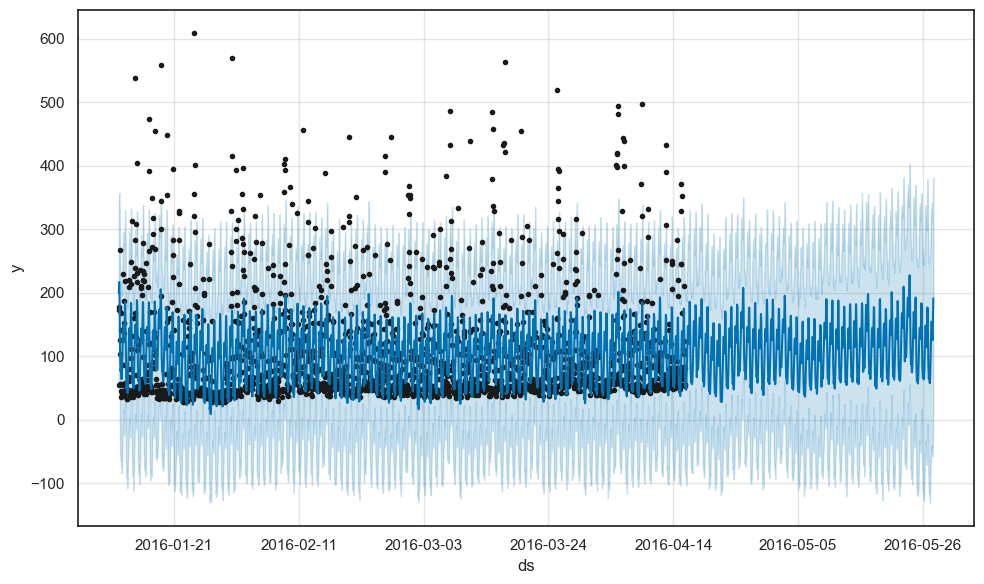

In [106]:
fig1= m.plot(forecast)

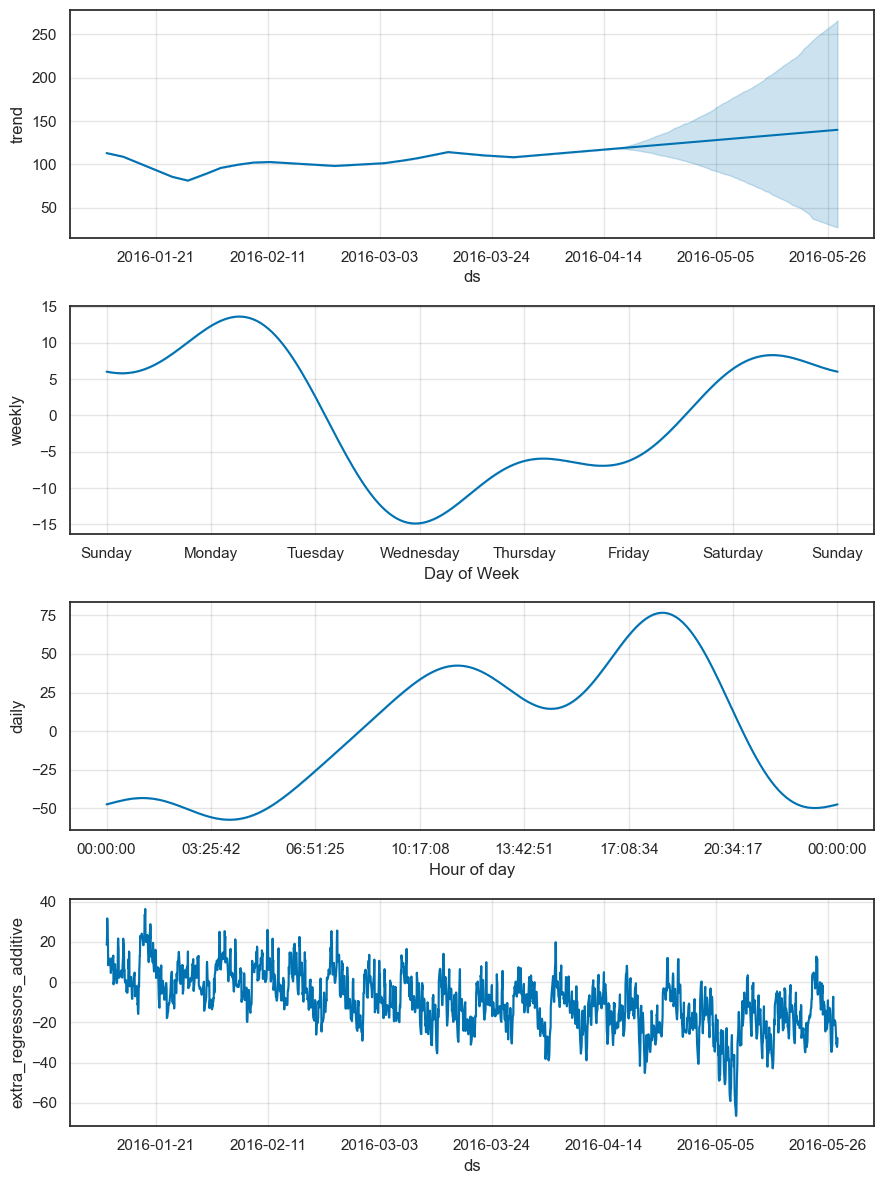

In [107]:
fig2= m.plot_components(forecast)

In [108]:
from prophet.utilities import regressor_coefficients
regressor_coefficients(m)
# the mean value of the prestandardised regressor (raw values) are displayed on the center column and if the regressor not standardised it is displayed as 0
#the coef column is the most important column because it shows the expected value i.e expected impact on y of a unit increased in the regressor
# the coefficent of temp9 is 0.54 that means that for eevry degree higher than the center 18.59 , the expected effect on ridership will be 0.54 or 54% increase

regressor regressor_mode     center  coef_lower      coef  coef_upper
0       temp9       additive  18.579274    0.542637  0.542637    0.542637
1        rh_4       additive  39.460754    1.721702  1.721702    1.721702
2       temp6       additive   5.927540   -0.174143 -0.174143   -0.174143
3    dewpoint       additive   2.731190   -0.084315 -0.084315   -0.084315
4        rh_5       additive  51.897878    0.314410  0.314410    0.314410
5   dayofweek       additive   0.000000   -3.478888 -3.478888   -3.478888
6        hour       additive   0.000000    0.468723  0.468723    0.468723
7    temp_out       additive   5.691860   -1.918842 -1.918842   -1.918842
8  visibility       additive  38.932656    0.079617  0.079617    0.079617

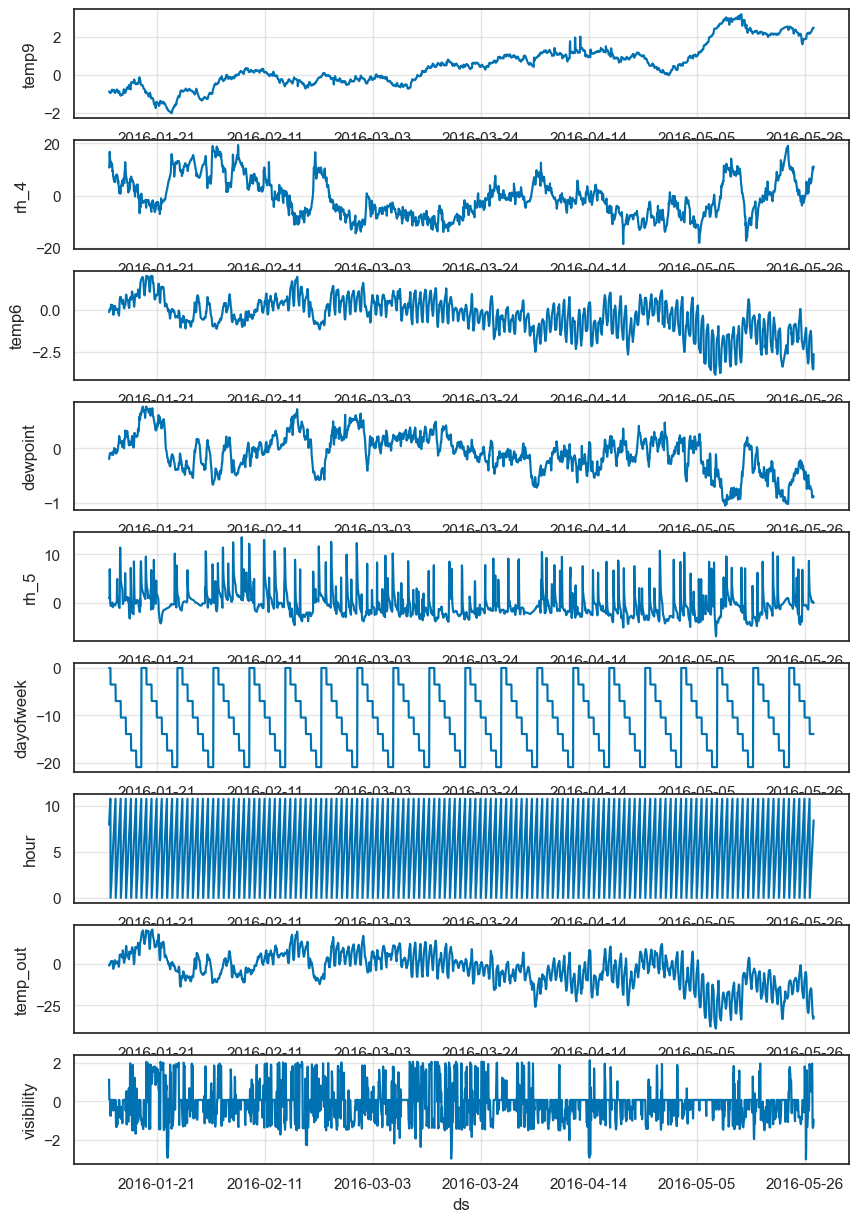

In [109]:
from prophet.plot import plot_forecast_component 
fig, axes= plt.subplots(len(regressor_coefficients(m)), figsize=(10,15))
for i, regressor in enumerate(regressor_coefficients(m)['regressor']):
    plot_forecast_component(m, forecast, regressor, axes[i])

plt.show()

In [110]:
from prophet.diagnostics import cross_validation, performance_metrics

cv_r = cross_validation(m, horizon='41 days', period='30 days', initial= '50 days')
df_p= performance_metrics(cv_r)
df_p

  0%|          | 0/1 [00:00<?, ?it/s]12:58:00 - cmdstanpy - INFO - Chain [1] start processing
12:58:01 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 1/1 [00:01<00:00,  1.98s/it]


horizon          mse       rmse        mae      mape     mdape  \
0    4 days 02:00:00  5098.150017  71.401331  48.138736  0.576725  0.432511   
1    4 days 03:00:00  5096.839151  71.392150  48.062957  0.575231  0.432511   
2    4 days 04:00:00  5094.228862  71.373867  47.934347  0.572144  0.432511   
3    4 days 05:00:00  5092.996576  71.365234  47.840830  0.569718  0.432511   
4    4 days 06:00:00  5103.060416  71.435708  48.121994  0.578083  0.436719   
..               ...          ...        ...        ...       ...       ...   
882 40 days 20:00:00  9234.918019  96.098481  60.010315  0.526208  0.511169   
883 40 days 21:00:00  9246.794870  96.160256  60.184521  0.528274  0.511169   
884 40 days 22:00:00  9275.371725  96.308731  60.579586  0.533604  0.518816   
885 40 days 23:00:00  9297.434259  96.423204  60.958480  0.540722  0.528647   
886 41 days 00:00:00  9326.183721  96.572168  61.383591  0.549029  0.532118   

        smape  coverage  
0    0.438445   0.94898  
1    0.437200   0.94898  
2    0.434736   0.94898  
3    0.432650   0.94898  
4    0.438099   0.94898  
..        ...       ...  
882  0.787873   1.00000  
883  0.791236   1.00000  
884  0.800257   1.00000  
885  0.813709   1.00000  
886  0.831716   1.00000  

[887 rows x 8 columns]

In [111]:
df_p.head()

horizon          mse       rmse        mae      mape     mdape  \
0 4 days 02:00:00  5098.150017  71.401331  48.138736  0.576725  0.432511   
1 4 days 03:00:00  5096.839151  71.392150  48.062957  0.575231  0.432511   
2 4 days 04:00:00  5094.228862  71.373867  47.934347  0.572144  0.432511   
3 4 days 05:00:00  5092.996576  71.365234  47.840830  0.569718  0.432511   
4 4 days 06:00:00  5103.060416  71.435708  48.121994  0.578083  0.436719   

      smape  coverage  
0  0.438445   0.94898  
1  0.437200   0.94898  
2  0.434736   0.94898  
3  0.432650   0.94898  
4  0.438099   0.94898

In [112]:
df_p.mean()

horizon     22 days 13:00:00
mse              6526.231466
rmse               77.356118
mae                48.543882
mape                0.486582
mdape               0.436994
smape               0.576772
coverage            0.984285
dtype: object

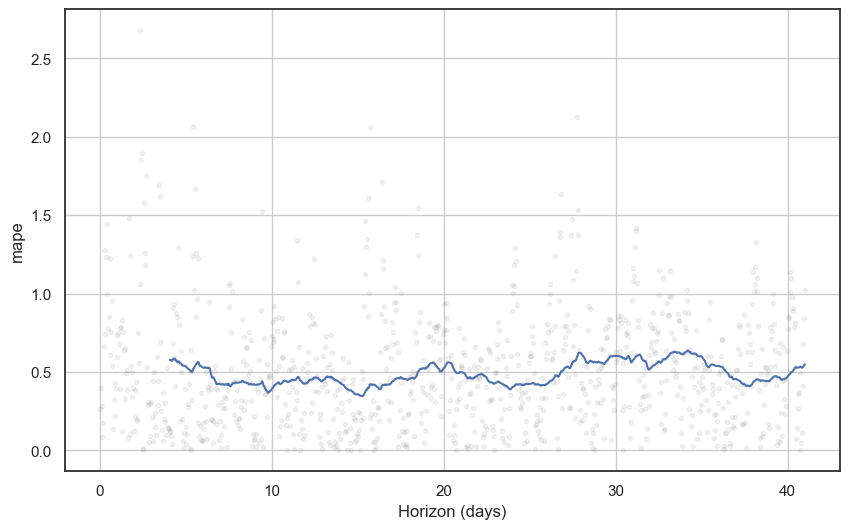

In [113]:
from prophet.plot import plot_cross_validation_metric

fig3 = plot_cross_validation_metric(cv_r, metric='mape')

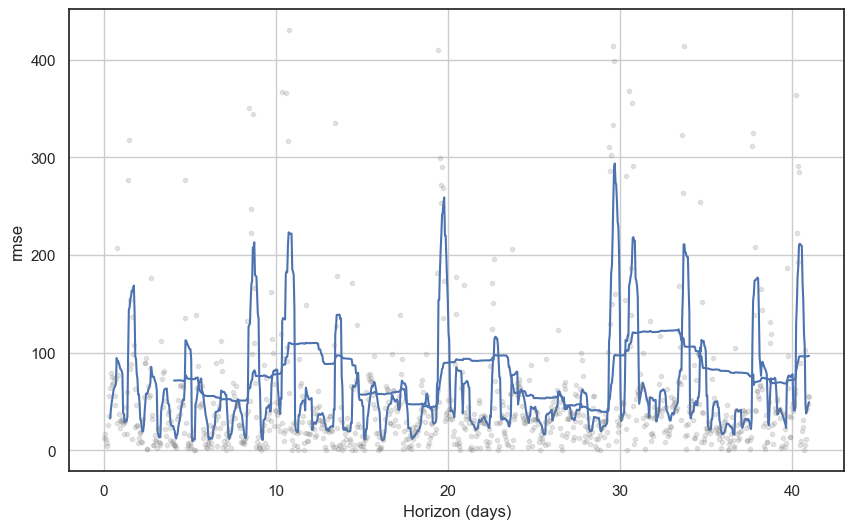

In [114]:
fig= plt.figure(figsize=(10,6))
ax= fig.add_subplot(111)
plot_cross_validation_metric(cv_r, metric='rmse', rolling_window= .01, ax=ax)

plot_cross_validation_metric(cv_r, metric='rmse', rolling_window= .1, ax=ax)

plt.show()

# Forecasting using Facebook Prophet (Multivariate) all variables

In [138]:
ed_fm= edata.reset_index()[['date','appl','lgt','temp1','rh_1','temp2','rh_2','temp3','rh_3','temp4','rh_4','temp5','rh_5','temp6','rh_6','temp7','rh_7','temp8','rh_8','temp9',
                             'rh_9','temp_out','press','rh_out','windspeed','visibility','dewpoint','hour', 'dayofweek', 'month','year', 'weekofyear']].rename({'date':'ds','appl':'y',
                             'lgt':'lgt','temp1':'temp1','rh_1':'rh_1','temp2':'temp2','rh_2':'rh_2','temp3':'temp3','rh_3':'rh_3','temp4':'temp4','rh_4':'rh_4','temp5':'temp5','rh_5':'rh_5',
                             'temp6':'temp6','rh_6':'rh_6','temp7':'temp7','rh_7':'rh_7','temp8':'temp8','rh_8':'rh_8','temp9':'temp9','rh_9':'rh_9','temp_out':'temp_out','press':'press','rh_out':'rh_out',
                             'windspeed':'windspeed','visibility':'visibility','dewpoint':'dewpoint', 'hour':'hour', 'dayofweek':'dayofweek', 'month':'month', 'year':'year', 'weekofyear':'weekofyear' }, axis='columns')

In [139]:
ed_fm

ds           y        lgt      temp1       rh_1  \
0    2016-01-11 17:00:00   55.000000  35.000000  19.890000  46.502778   
1    2016-01-11 18:00:00  176.666667  51.666667  19.897778  45.879028   
2    2016-01-11 19:00:00  173.333333  25.000000  20.495556  52.805556   
3    2016-01-11 20:00:00  125.000000  35.000000  20.961111  48.453333   
4    2016-01-11 21:00:00  103.333333  23.333333  21.311667  45.768333   
...                  ...         ...        ...        ...        ...   
3285 2016-05-27 14:00:00  101.666667   1.666667  25.544444  46.638889   
3286 2016-05-27 15:00:00   76.666667   0.000000  25.500000  45.677639   
3287 2016-05-27 16:00:00  135.000000   0.000000  25.487778  46.250000   
3288 2016-05-27 17:00:00  180.000000   3.333333  25.533333  46.783333   
3289 2016-05-27 18:00:00  430.000000  10.000000  25.500000  46.600000   

          temp2       rh_2      temp3       rh_3      temp4  ...       press  \
0     19.200000  44.626528  19.790000  44.897778  18.932778  ...  733.750000   
1     19.268889  44.438889  19.770000  44.863333  18.908333  ...  734.266667   
2     19.925556  46.061667  20.052222  47.227361  18.969444  ...  734.791667   
3     20.251111  45.632639  20.213889  47.268889  19.190833  ...  735.283333   
4     20.587778  44.961111  20.373333  46.164444  19.425556  ...  735.566667   
...         ...        ...        ...        ...        ...  ...         ...   
3285  26.421369  41.205054  28.397778  41.160000  24.666667  ...  755.800000   
3286  26.154762  41.041238  28.240000  40.306667  24.694444  ...  755.675000   
3287  26.000000  41.736190  27.953333  40.607778  24.700000  ...  755.375000   
3288  25.772190  42.495476  27.164444  41.247778  24.700000  ...  755.200000   
3289  25.264286  42.971429  26.823333  41.156667  24.700000  ...  755.200000   

         rh_out  windspeed  visibility   dewpoint  hour  dayofweek  month  \
0     92.000000   6.166667   53.416667   5.050000  17.0        0.0    1.0   
1     91.583333   5.416667   40.000000   4.658333  18.0        0.0    1.0   
2     89.750000   6.000000   40.000000   4.391667  19.0        0.0    1.0   
3     87.583333   6.000000   40.000000   4.016667  20.0        0.0    1.0   
4     87.416667   6.000000   40.000000   3.816667  21.0        0.0    1.0   
...         ...        ...         ...        ...   ...        ...    ...   
3285  59.000000   2.000000   21.583333  13.483333  14.0        4.0    5.0   
3286  57.333333   2.000000   21.833333  13.266667  15.0        4.0    5.0   
3287  55.000000   2.416667   22.583333  13.283333  16.0        4.0    5.0   
3288  55.833333   3.416667   24.083333  13.316667  17.0        4.0    5.0   
3289  57.000000   4.000000   27.000000  13.200000  18.0        4.0    5.0   

        year  weekofyear  
0     2016.0         2.0  
1     2016.0         2.0  
2     2016.0         2.0  
3     2016.0         2.0  
4     2016.0         2.0  
...      ...         ...  
3285  2016.0        21.0  
3286  2016.0        21.0  
3287  2016.0        21.0  
3288  2016.0        21.0  
3289  2016.0        21.0  

[3290 rows x 32 columns]

In [140]:
train= ed_fm[(ed_fm['ds'] >= '2016-01-11') & (ed_fm['ds'] <= '2016-04-16')]
test= ed_fm[(ed_fm['ds'] >'2016-04-16')]

In [141]:
ed_fm.shape

(3290, 32)

In [142]:
train.shape

(2288, 32)

In [143]:
test.shape

(1002, 32)

In [144]:
test

ds           y        lgt      temp1       rh_1  \
2288 2016-04-16 01:00:00   55.000000   0.000000  22.514722  41.591667   
2289 2016-04-16 02:00:00   50.000000   0.000000  22.340000  41.483333   
2290 2016-04-16 03:00:00   56.666667   0.000000  22.235000  41.500000   
2291 2016-04-16 04:00:00   48.333333   0.000000  22.105556  41.609444   
2292 2016-04-16 05:00:00   53.333333   0.000000  21.926667  41.750000   
...                  ...         ...        ...        ...        ...   
3285 2016-05-27 14:00:00  101.666667   1.666667  25.544444  46.638889   
3286 2016-05-27 15:00:00   76.666667   0.000000  25.500000  45.677639   
3287 2016-05-27 16:00:00  135.000000   0.000000  25.487778  46.250000   
3288 2016-05-27 17:00:00  180.000000   3.333333  25.533333  46.783333   
3289 2016-05-27 18:00:00  430.000000  10.000000  25.500000  46.600000   

          temp2       rh_2      temp3       rh_3      temp4  ...       press  \
2288  20.077778  44.687778  23.902222  39.433333  21.932778  ...  744.541667   
2289  19.933889  44.773333  24.000000  39.530000  21.880278  ...  744.641667   
2290  19.775556  44.857222  24.045833  39.704583  21.795556  ...  744.700000   
2291  19.666667  45.040000  24.194444  39.808333  21.760000  ...  744.783333   
2292  19.577778  45.183333  24.166667  39.887778  21.715000  ...  744.983333   
...         ...        ...        ...        ...        ...  ...         ...   
3285  26.421369  41.205054  28.397778  41.160000  24.666667  ...  755.800000   
3286  26.154762  41.041238  28.240000  40.306667  24.694444  ...  755.675000   
3287  26.000000  41.736190  27.953333  40.607778  24.700000  ...  755.375000   
3288  25.772190  42.495476  27.164444  41.247778  24.700000  ...  755.200000   
3289  25.264286  42.971429  26.823333  41.156667  24.700000  ...  755.200000   

         rh_out  windspeed  visibility   dewpoint  hour  dayofweek  month  \
2288  78.666667   6.416667   40.000000   6.783333   1.0        5.0    4.0   
2289  81.416667   7.000000   40.000000   7.025000   2.0        5.0    4.0   
2290  83.250000   6.583333   40.000000   7.116667   3.0        5.0    4.0   
2291  86.250000   5.583333   35.000000   7.125000   4.0        5.0    4.0   
2292  88.416667   5.000000   27.583333   7.425000   5.0        5.0    4.0   
...         ...        ...         ...        ...   ...        ...    ...   
3285  59.000000   2.000000   21.583333  13.483333  14.0        4.0    5.0   
3286  57.333333   2.000000   21.833333  13.266667  15.0        4.0    5.0   
3287  55.000000   2.416667   22.583333  13.283333  16.0        4.0    5.0   
3288  55.833333   3.416667   24.083333  13.316667  17.0        4.0    5.0   
3289  57.000000   4.000000   27.000000  13.200000  18.0        4.0    5.0   

        year  weekofyear  
2288  2016.0        15.0  
2289  2016.0        15.0  
2290  2016.0        15.0  
2291  2016.0        15.0  
2292  2016.0        15.0  
...      ...         ...  
3285  2016.0        21.0  
3286  2016.0        21.0  
3287  2016.0        21.0  
3288  2016.0        21.0  
3289  2016.0        21.0  

[1002 rows x 32 columns]

In [145]:
ed_fm.columns

Index(['ds', 'y', 'lgt', 'temp1', 'rh_1', 'temp2', 'rh_2', 'temp3', 'rh_3',
       'temp4', 'rh_4', 'temp5', 'rh_5', 'temp6', 'rh_6', 'temp7', 'rh_7',
       'temp8', 'rh_8', 'temp9', 'rh_9', 'temp_out', 'press', 'rh_out',
       'windspeed', 'visibility', 'dewpoint', 'hour', 'dayofweek', 'month',
       'year', 'weekofyear'],
      dtype='object')

In [275]:
#model=Prophet(interval_width=0.95, changepoint_prior_scale=0.5)
#model=Prophet(interval_width=0.95, changepoint_prior_scale=0.5, weekly_seasonality=True, yearly_seasonality=False, daily_seasonality=True)
#model.add_seasonality(name='weekly', period=30, fourier_order=3)
model= Prophet(mcmc_samples=300)

In [276]:
#m.add_regressor('year', standardize=False)
model.add_regressor('lgt')
model.add_regressor('temp1')   
model.add_regressor('rh_1')
model.add_regressor('temp2')
model.add_regressor('rh_2')
model.add_regressor('temp3')
model.add_regressor('rh_3')   
model.add_regressor('temp4')
model.add_regressor('rh_4')
model.add_regressor('temp5')
model.add_regressor('rh_5')
model.add_regressor('temp6')   
model.add_regressor('rh_6')
model.add_regressor('temp7')
model.add_regressor('rh_7')
model.add_regressor('temp8')
model.add_regressor('rh_8')   
model.add_regressor('temp9')
model.add_regressor('rh_9')
model.add_regressor('temp_out')
model.add_regressor('press')
model.add_regressor('rh_out')   
model.add_regressor('windspeed')
model.add_regressor('visibility')
model.add_regressor('dewpoint')
model.add_regressor('hour', standardize=False)
model.add_regressor('dayofweek', standardize=False)
model.add_regressor('month', standardize=False)
model.add_regressor('year', standardize=False)
model.add_regressor('weekofyear', standardize=False)

In [277]:
model.fit(train)
#model.fit(train)

17:48:27 - cmdstanpy - INFO - Chain [1] start processing
17:48:29 - cmdstanpy - INFO - Chain [1] done processing


In [278]:
future_data= model.make_future_dataframe(periods=1002, freq= 'H')  #1002

In [279]:
future_data.tail()

ds
3285 2016-05-27 14:00:00
3286 2016-05-27 15:00:00
3287 2016-05-27 16:00:00
3288 2016-05-27 17:00:00
3289 2016-05-27 18:00:00

In [280]:
ed_fm.columns

Index(['ds', 'y', 'lgt', 'temp1', 'rh_1', 'temp2', 'rh_2', 'temp3', 'rh_3',
       'temp4', 'rh_4', 'temp5', 'rh_5', 'temp6', 'rh_6', 'temp7', 'rh_7',
       'temp8', 'rh_8', 'temp9', 'rh_9', 'temp_out', 'press', 'rh_out',
       'windspeed', 'visibility', 'dewpoint', 'hour', 'dayofweek', 'month',
       'year', 'weekofyear'],
      dtype='object')

In [281]:
future_data['lgt']= ed_fm['lgt']
future_data['temp1']= ed_fm['temp1']
future_data['rh_1']= ed_fm['rh_1']
future_data['temp2']= ed_fm['temp2']
future_data['rh_2']= ed_fm['rh_2']
future_data['temp3']= ed_fm['temp3']
future_data['rh_3']= ed_fm['rh_3']
future_data['temp4']= ed_fm['temp4']
future_data['rh_4']= ed_fm['rh_4']
future_data['temp5']= ed_fm['temp5']
future_data['rh_5']= ed_fm['rh_5']
future_data['temp6']= ed_fm['temp6']
future_data['rh_6']= ed_fm['rh_6']
future_data['temp7']= ed_fm['temp7']
future_data['rh_7']= ed_fm['rh_7']
future_data['temp8']= ed_fm['temp8']
future_data['rh_8']= ed_fm['rh_8']
future_data['temp9']= ed_fm['temp9']
future_data['rh_9']= ed_fm['rh_9']
future_data['temp_out']= ed_fm['temp_out']
future_data['press']= ed_fm['press']
future_data['rh_out']= ed_fm['rh_out']
future_data['windspeed']= ed_fm['windspeed']
future_data['visibility']= ed_fm['visibility']
future_data['dewpoint']= ed_fm['dewpoint']
future_data['hour']= ed_fm['hour']
future_data['dayofweek']= ed_fm['dayofweek']
future_data['month']= ed_fm['month']
future_data['year']= ed_fm['year']
future_data['weekofyear']= ed_fm['weekofyear']

In [282]:
future_data.tail()

ds        lgt      temp1       rh_1      temp2  \
3285 2016-05-27 14:00:00   1.666667  25.544444  46.638889  26.421369   
3286 2016-05-27 15:00:00   0.000000  25.500000  45.677639  26.154762   
3287 2016-05-27 16:00:00   0.000000  25.487778  46.250000  26.000000   
3288 2016-05-27 17:00:00   3.333333  25.533333  46.783333  25.772190   
3289 2016-05-27 18:00:00  10.000000  25.500000  46.600000  25.264286   

           rh_2      temp3       rh_3      temp4       rh_4  ...    press  \
3285  41.205054  28.397778  41.160000  24.666667  45.883889  ...  755.800   
3286  41.041238  28.240000  40.306667  24.694444  45.270000  ...  755.675   
3287  41.736190  27.953333  40.607778  24.700000  45.476667  ...  755.375   
3288  42.495476  27.164444  41.247778  24.700000  45.658889  ...  755.200   
3289  42.971429  26.823333  41.156667  24.700000  45.963333  ...  755.200   

         rh_out  windspeed  visibility   dewpoint  hour  dayofweek  month  \
3285  59.000000   2.000000   21.583333  13.483333  14.0        4.0    5.0   
3286  57.333333   2.000000   21.833333  13.266667  15.0        4.0    5.0   
3287  55.000000   2.416667   22.583333  13.283333  16.0        4.0    5.0   
3288  55.833333   3.416667   24.083333  13.316667  17.0        4.0    5.0   
3289  57.000000   4.000000   27.000000  13.200000  18.0        4.0    5.0   

        year  weekofyear  
3285  2016.0        21.0  
3286  2016.0        21.0  
3287  2016.0        21.0  
3288  2016.0        21.0  
3289  2016.0        21.0  

[5 rows x 31 columns]

In [283]:
forecast_data = model.predict(future_data)

In [284]:
forecast_data.head()

ds      trend  yhat_lower  yhat_upper  trend_lower  \
0 2016-01-11 17:00:00  54.997531   66.549064  345.683068    54.997531   
1 2016-01-11 18:00:00  54.996783  103.072139  369.398973    54.996783   
2 2016-01-11 19:00:00  54.996036   91.899535  363.179937    54.996036   
3 2016-01-11 20:00:00  54.995288   41.347337  316.459091    54.995288   
4 2016-01-11 21:00:00  54.994540  -31.074961  243.500666    54.994540   

   trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0    54.997531      146.518576            146.518576            146.518576   
1    54.996783      179.680791            179.680791            179.680791   
2    54.996036      166.088736            166.088736            166.088736   
3    54.995288      128.013709            128.013709            128.013709   
4    54.994540       48.422328             48.422328             48.422328   

       daily  ...  windspeed  windspeed_lower  windspeed_upper       year  \
0  41.494966  ...   4.170340         4.170340         4.170340  52.884208   
1  49.250436  ...   2.447486         2.447486         2.447486  52.884208   
2  36.420477  ...   3.787484         3.787484         3.787484  52.884208   
3   6.590144  ...   3.787484         3.787484         3.787484  52.884208   
4 -25.743887  ...   3.787484         3.787484         3.787484  52.884208   

   year_lower  year_upper  multiplicative_terms  multiplicative_terms_lower  \
0   52.884208   52.884208                   0.0                         0.0   
1   52.884208   52.884208                   0.0                         0.0   
2   52.884208   52.884208                   0.0                         0.0   
3   52.884208   52.884208                   0.0                         0.0   
4   52.884208   52.884208                   0.0                         0.0   

   multiplicative_terms_upper        yhat  
0                         0.0  201.516107  
1                         0.0  234.677574  
2                         0.0  221.084771  
3                         0.0  183.008997  
4                         0.0  103.416868  

[5 rows x 112 columns]

In [285]:
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
3285 2016-05-27 14:00:00  184.088390   53.888384  318.633038
3286 2016-05-27 15:00:00  163.922488   31.277476  294.253610
3287 2016-05-27 16:00:00  167.852073   34.838332  307.478927
3288 2016-05-27 17:00:00  184.934105   55.557422  318.134215
3289 2016-05-27 18:00:00  196.598114   61.931083  330.794015

In [286]:
from sklearn.metrics import r2_score
print('r2:', r2_score(ed_fm['y'], forecast_data['yhat']))

r2: 0.34035518368334017


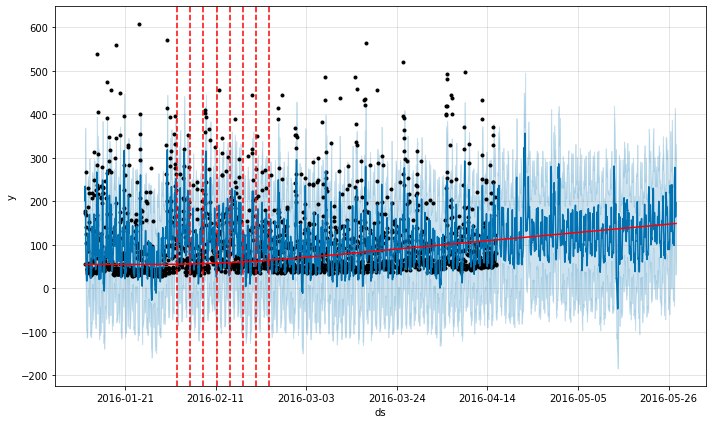

In [287]:
from prophet.plot import add_changepoints_to_plot
fig = model.plot(forecast_data)
a = add_changepoints_to_plot(fig.gca(), model, forecast_data)

In [288]:
print(model.params['delta'])

[[-0.00114033  0.00031164  0.00226672  0.00436557  0.00681773  0.00885576
   0.0107244   0.0123717   0.0129035   0.0128107   0.0128317   0.0123547
   0.011451    0.0103952   0.00885712  0.00708805  0.00571092  0.00413386
   0.00248546  0.00107469  0.00012651 -0.0001242  -0.00043996 -0.00071001
  -0.00072536]]


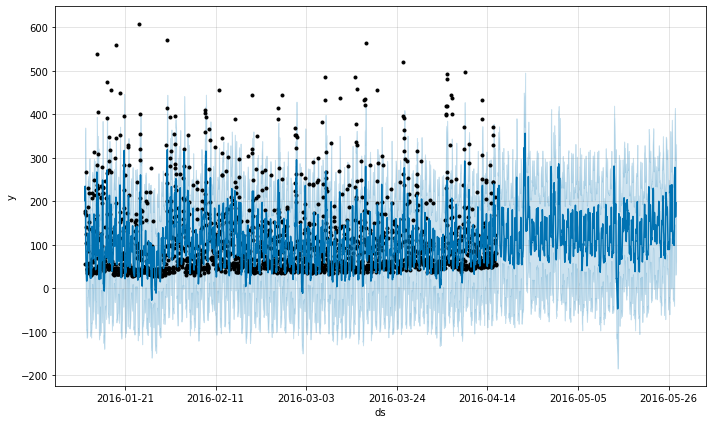

In [289]:
fig4= model.plot(forecast_data)

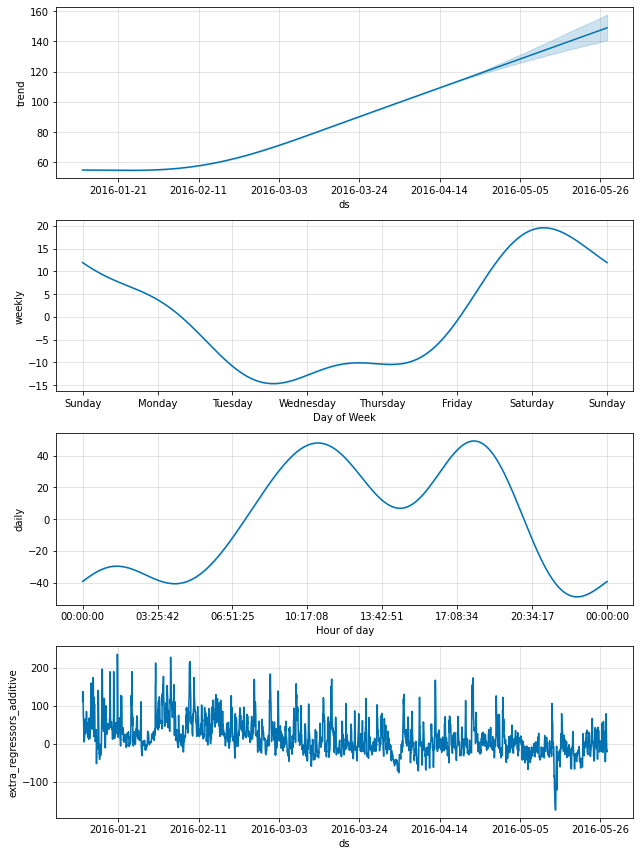

In [290]:
fig5= model.plot_components(forecast_data)

In [291]:
from prophet.utilities import regressor_coefficients
regressor_coefficients(model)
# for temp1, the ridership is down by 724% when compared to other regressors

regressor regressor_mode      center  coef_lower       coef  coef_upper
0          lgt       additive    4.578963    2.217438   2.217438    2.217438
1        temp1       additive   21.062722   -7.249317  -7.249317   -7.249317
2         rh_1       additive   40.390336    7.879271   7.879271    7.879271
3        temp2       additive   19.577574   -8.698547  -8.698547   -8.698547
4         rh_2       additive   40.864579   -9.320595  -9.320595   -9.320595
5        temp3       additive   21.400633   31.362210  31.362210   31.362210
6         rh_3       additive   39.799456   13.721900  13.721900   13.721900
7        temp4       additive   19.949201   -2.310221  -2.310221   -2.310221
8         rh_4       additive   39.460754   -5.631133  -5.631133   -5.631133
9        temp5       additive   18.791068   -2.358407  -2.358407   -2.358407
10        rh_5       additive   51.897878    0.271082   0.271082    0.271082
11       temp6       additive    5.927540    0.624960   0.624960    0.624960
12        rh_6       additive   67.543798   -0.060778  -0.060778   -0.060778
13       temp7       additive   19.371121    1.624820   1.624820    1.624820
14        rh_7       additive   35.609106   -1.236392  -1.236392   -1.236392
15       temp8       additive   21.320473   11.352115  11.352115   11.352115
16        rh_8       additive   43.298883   -2.291741  -2.291741   -2.291741
17       temp9       additive   18.579274  -22.502667 -22.502667  -22.502667
18        rh_9       additive   41.939367   -1.490145  -1.490145   -1.490145
19    temp_out       additive    5.691860   -0.678454  -0.678454   -0.678454
20       press       additive  755.178227    0.373351   0.373351    0.373351
21      rh_out       additive   82.593641    0.922363   0.922363    0.922363
22   windspeed       additive    4.351216    2.297138   2.297138    2.297138
23  visibility       additive   38.932656    0.170153   0.170153    0.170153
24    dewpoint       additive    2.731190    0.247285   0.247285    0.247285
25        hour       additive    0.000000    0.307101   0.307101    0.307101
26   dayofweek       additive    0.000000   -4.022087  -4.022087   -4.022087
27       month       additive    0.000000   -7.910888  -7.910888   -7.910888
28        year       additive    0.000000    0.026232   0.026232    0.026232
29  weekofyear       additive    0.000000   -0.015614  -0.015614   -0.015614

In [292]:
from prophet.plot import plot_forecast_component 
#fig, axes= plt.subplots(len(regressor_coefficients(model)), figsize=(10, 20))
#for i, regressor in enumerate(regressor_coefficients(model)['regressor']):
    #plot_forecast_component(model, forecast, regressor, axes[i])

#plt.show()

In [87]:
# converting the data from log to normal data
#forecast_data_orig= forecast_data 
#forecast_data_orig['yhat']= np.exp(forecast_data_orig['yhat'])
#forecast_data_orig['yhat_lower']= np.exp(forecast_data_orig['yhat_lower'])
#forecast_data_orig['yhat_upper']= np.exp(forecast_data_orig['yhat_upper'])

In [88]:
#fig6= model.plot(forecast_data_orig)

In [297]:
from prophet.diagnostics import cross_validation, performance_metrics

cv_result = cross_validation(model, horizon='41 days', period='41 days', initial= '50 days')
df_fm= performance_metrics(cv_result)
df_fm

  0%|          | 0/1 [00:00<?, ?it/s]

17:50:22 - cmdstanpy - INFO - Chain [1] start processing
17:50:23 - cmdstanpy - INFO - Chain [1] done processing


horizon           mse        rmse        mae      mape     mdape  \
0    4 days 02:00:00   5658.506582   75.223046  55.325518  0.695215  0.548584   
1    4 days 03:00:00   5691.833903   75.444244  55.788123  0.706668  0.554876   
2    4 days 04:00:00   5740.158450   75.763833  56.448859  0.722526  0.556203   
3    4 days 05:00:00   5793.629782   76.115897  57.133805  0.736457  0.557863   
4    4 days 06:00:00   5814.652073   76.253866  57.480060  0.747427  0.560392   
..               ...           ...         ...        ...       ...       ...   
882 40 days 20:00:00  10122.039570  100.608347  73.226831  0.810252  0.706767   
883 40 days 21:00:00  10037.857398  100.189108  72.583787  0.805471  0.696449   
884 40 days 22:00:00  10010.825561  100.054113  72.320494  0.804129  0.696449   
885 40 days 23:00:00   9970.325178   99.851516  71.913505  0.799799  0.679694   
886 41 days 00:00:00   9964.337513   99.821528  71.838873  0.799531  0.677337   

        smape  coverage  
0    0.714589  0.928571  
1    0.731589  0.928571  
2    0.750916  0.928571  
3    0.769826  0.928571  
4    0.786953  0.928571  
..        ...       ...  
882  0.747984  0.806122  
883  0.746180  0.806122  
884  0.747737  0.806122  
885  0.748448  0.806122  
886  0.753699  0.806122  

[887 rows x 8 columns]

In [298]:
df_fm.head()

horizon          mse       rmse        mae      mape     mdape  \
0 4 days 02:00:00  5658.506582  75.223046  55.325518  0.695215  0.548584   
1 4 days 03:00:00  5691.833903  75.444244  55.788123  0.706668  0.554876   
2 4 days 04:00:00  5740.158450  75.763833  56.448859  0.722526  0.556203   
3 4 days 05:00:00  5793.629782  76.115897  57.133805  0.736457  0.557863   
4 4 days 06:00:00  5814.652073  76.253866  57.480060  0.747427  0.560392   

      smape  coverage  
0  0.714589  0.928571  
1  0.731589  0.928571  
2  0.750916  0.928571  
3  0.769826  0.928571  
4  0.786953  0.928571

In [299]:
df_fm.mean()

horizon     22 days 13:00:00
mse               7453.34005
rmse               84.311928
mae                 63.19633
mape                0.781764
mdape               0.690632
smape               0.911793
coverage            0.887583
dtype: object

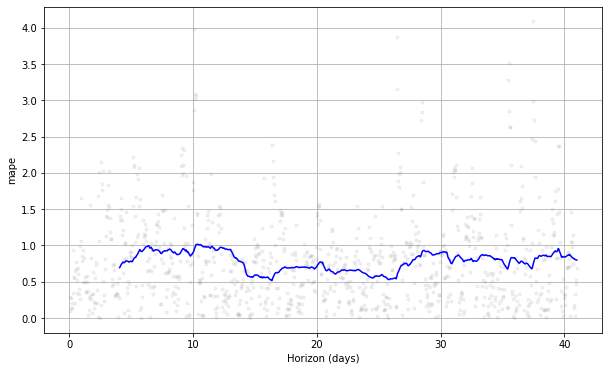

In [300]:
from prophet.plot import plot_cross_validation_metric

fig4 = plot_cross_validation_metric(cv_result, metric='mape')

In [301]:
df_fm['mape'].values[0]

0.6952154398285433

In [43]:
import itertools
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from prophet.diagnostics import cross_validation, performance_metrics

## Contributing regressors

In [115]:
ed_fm2= ed_fm[['ds','y','lgt', 'rh_1', 'temp3', 'rh_3', 'rh_5', 'temp6', 'rh_6', 'temp7', 'temp8', 'press', 'rh_out', 'windspeed', 'visibility', 'dewpoint', 'hour', 'year']]

In [116]:
train_2= ed_fm2[(ed_fm2['ds'] >= '2016-01-11') & (ed_fm2['ds'] <= '2016-04-16')]
test_2= ed_fm2[(ed_fm2['ds'] >'2016-04-16')]

In [259]:
#model_2= Prophet(interval_width=0.95, changepoint_prior_scale=0.5)
model_2= Prophet(mcmc_samples=300)

In [260]:
model_2.add_regressor('lgt')   
model_2.add_regressor('rh_1')
model_2.add_regressor('temp3')
model_2.add_regressor('rh_3')   
model_2.add_regressor('rh_5')
model_2.add_regressor('temp6')   
model_2.add_regressor('rh_6')
model_2.add_regressor('temp7')
model_2.add_regressor('temp8')
model_2.add_regressor('press')
model_2.add_regressor('rh_out')   
model_2.add_regressor('windspeed')
model_2.add_regressor('visibility')
model_2.add_regressor('dewpoint')
model_2.add_regressor('hour', standardize=False)
model_2.add_regressor('year', standardize=False)

In [261]:
model_2.fit(train_2)

17:28:51 - cmdstanpy - INFO - CmdStan installation C:\Users\benny\AppData\Roaming\Python\Python39\site-packages\prophet\stan_model\cmdstan-2.26.1 missing makefile, cannot get version.
17:28:51 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
17:28:51 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:36:12 - cmdstanpy - INFO - CmdStan done processing.
17:36:12 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Excep

In [262]:
train_2.columns

Index(['ds', 'y', 'lgt', 'rh_1', 'temp3', 'rh_3', 'rh_5', 'temp6', 'rh_6',
       'temp7', 'temp8', 'press', 'rh_out', 'windspeed', 'visibility',
       'dewpoint', 'hour', 'year'],
      dtype='object')

In [263]:
future_da2= model_2.make_future_dataframe(periods=1002, freq= 'H')  #1002

In [264]:
future_da2['lgt']= ed_fm2['lgt']
future_da2['rh_1']= ed_fm2['rh_1']
future_da2['temp3']= ed_fm2['temp3']
future_da2['rh_3']= ed_fm2['rh_3']
future_da2['rh_5']= ed_fm2['rh_5']
future_da2['temp6']= ed_fm2['temp6']
future_da2['rh_6']= ed_fm2['rh_6']
future_da2['temp7']= ed_fm2['temp7']
future_da2['temp8']= ed_fm2['temp8']
future_da2['press']= ed_fm2['press']
future_da2['rh_out']= ed_fm2['rh_out']
future_da2['windspeed']= ed_fm2['windspeed']
future_da2['visibility']= ed_fm2['visibility']
future_da2['dewpoint']= ed_fm2['dewpoint']
future_da2['hour']= ed_fm2['hour']
future_da2['year']= ed_fm2['year']

In [265]:
forecast_da2 = model_2.predict(future_da2)

In [266]:
forecast_da2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
3285 2016-05-27 14:00:00  157.743082   52.047464  261.885214
3286 2016-05-27 15:00:00  150.008172   47.746483  253.114673
3287 2016-05-27 16:00:00  163.816539   56.315585  257.031016
3288 2016-05-27 17:00:00  185.761149   88.262859  285.966411
3289 2016-05-27 18:00:00  206.616529  106.529602  312.375082

In [267]:
from sklearn.metrics import r2_score
print('r2:', r2_score(ed_fm2['y'], forecast_da2['yhat']))

r2: 0.3194404329466999


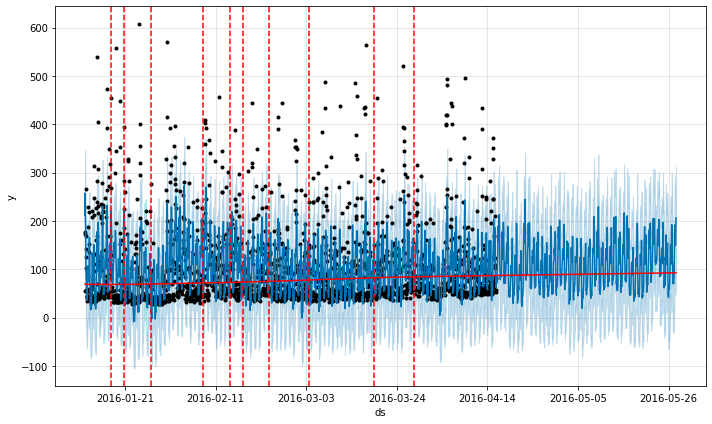

In [268]:
from prophet.plot import add_changepoints_to_plot
fig = model_2.plot(forecast_da2)
a = add_changepoints_to_plot(fig.gca(), model_2, forecast_da2)

In [269]:
print(model_2.params['delta'])

[[ 0.0637      0.00398191 -0.0180775  ... -0.0104722  -0.0199489
   0.0221347 ]
 [-0.0135862   0.0667723   0.0194786  ... -0.00644285  0.0204508
  -0.0505418 ]
 [-0.0115962  -0.00086173  0.03769    ...  0.00099036  0.00427413
   0.0238333 ]
 ...
 [-0.0472963   0.0928046   0.0440367  ... -0.0170938   0.0233101
  -0.0334621 ]
 [-0.00231237 -0.00999994  0.0559689  ...  0.00910057 -0.00429654
   0.00392069]
 [-0.0126773  -0.00019044  0.016084   ...  0.0378652   0.00333698
  -0.0298458 ]]


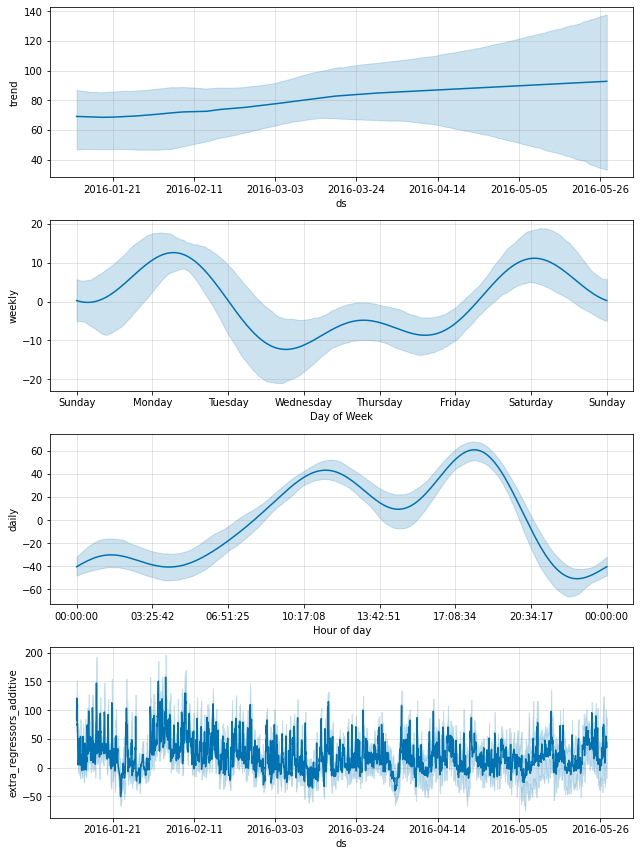

In [270]:
fig5= model_2.plot_components(forecast_da2)

In [271]:
from prophet.utilities import regressor_coefficients
regressor_coefficients(model_2)

regressor regressor_mode      center  coef_lower       coef  coef_upper
0          lgt       additive    4.578963    1.897778   2.229821    2.493208
1         rh_1       additive   40.390336   -2.800806   1.661945    4.315588
2        temp3       additive   21.400633   12.439036  15.562518   18.535694
3         rh_3       additive   39.799456   -1.412203   2.797659    6.320792
4         rh_5       additive   51.897878   -0.536189  -0.276187    0.005121
5        temp6       additive    5.927540   -2.467491   0.997968    4.966352
6         rh_6       additive   67.543798   -0.172823   0.143820    0.788213
7        temp7       additive   19.371121   -9.998864  -6.353918   -0.981994
8        temp8       additive   21.320473   -2.453162   3.224320    8.255758
9        press       additive  755.178227   -0.101469   0.299787    0.673620
10      rh_out       additive   82.593641   -0.153291   0.271635    0.640129
11   windspeed       additive    4.351216   -0.599412   1.114457    2.740506
12  visibility       additive   38.932656    0.020607   0.162607    0.308576
13    dewpoint       additive    2.731190  -10.512917  -6.594586   -2.429218
14        hour       additive    0.000000    0.109497   0.936631    2.303815
15        year       additive    0.000000   -0.001591   0.005348    0.012176

In [272]:
from prophet.diagnostics import cross_validation, performance_metrics

cv_result2 = cross_validation(model_2, horizon='41 days', period='30 days', initial= '50 days')
df_fm_2= performance_metrics(cv_result2)
df_fm_2

  0%|          | 0/1 [00:00<?, ?it/s]

17:38:08 - cmdstanpy - INFO - CmdStan installation C:\Users\benny\AppData\Roaming\Python\Python39\site-packages\prophet\stan_model\cmdstan-2.26.1 missing makefile, cannot get version.
17:38:08 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
17:38:08 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:41:07 - cmdstanpy - INFO - CmdStan done processing.
17:41:07 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, co

horizon          mse       rmse        mae      mape     mdape  \
0    4 days 02:00:00  5086.615872  71.320515  46.391309  0.497250  0.393427   
1    4 days 03:00:00  5086.368602  71.318782  46.373292  0.497021  0.393427   
2    4 days 04:00:00  5086.520387  71.319846  46.412042  0.497951  0.393427   
3    4 days 05:00:00  5087.201625  71.324621  46.472914  0.499096  0.393427   
4    4 days 06:00:00  5087.786810  71.328724  46.492065  0.500796  0.403212   
..               ...          ...        ...        ...       ...       ...   
882 40 days 20:00:00  6371.524044  79.821827  53.891241  0.520691  0.463383   
883 40 days 21:00:00  6328.101094  79.549363  53.292543  0.515873  0.436524   
884 40 days 22:00:00  6307.676753  79.420884  52.905725  0.512465  0.433215   
885 40 days 23:00:00  6268.609059  79.174548  52.311636  0.504518  0.411981   
886 41 days 00:00:00  6251.033099  79.063475  51.922672  0.498302  0.403994   

        smape  coverage  
0    0.419384  0.928571  
1    0.418903  0.928571  
2    0.419879  0.928571  
3    0.421178  0.928571  
4    0.421461  0.928571  
..        ...       ...  
882  0.435238  0.918367  
883  0.431613  0.918367  
884  0.429009  0.918367  
885  0.423603  0.918367  
886  0.419106  0.918367  

[887 rows x 8 columns]

In [273]:
df_fm_2.mean()

horizon     22 days 13:00:00
mse              5000.573295
rmse               68.575072
mae                43.182912
mape                0.438475
mdape               0.347985
smape               0.388834
coverage            0.929434
dtype: object

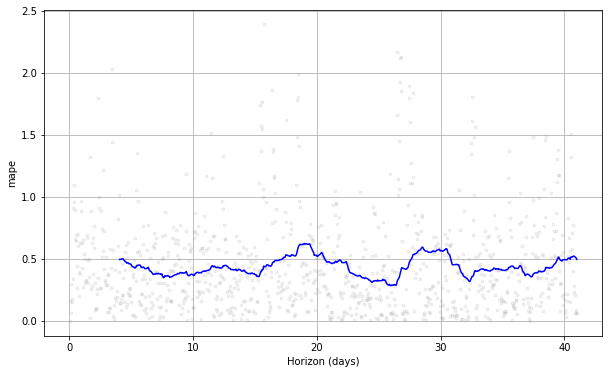

In [274]:
from prophet.plot import plot_cross_validation_metric

fig4 = plot_cross_validation_metric(cv_result2, metric='mape')

In [ ]:
#modelling with rolling window 

In [126]:
# utlizing winsorizing techinque to remove outliers
from scipy import stats
df4= ed_fm.copy().dropna()
df4['y']= stats.mstats.winsorize(df4['y'], limits=(0, .05), axis=0)

<AxesSubplot:title={'center':'appliance energy usage'}, xlabel='ds'>

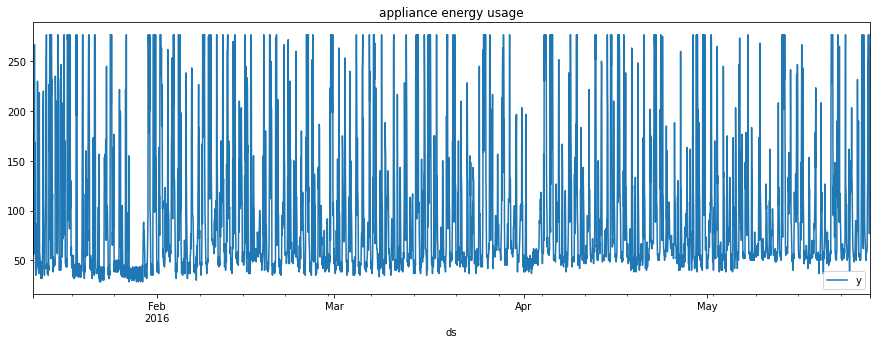

In [127]:
df4.plot(kind='line', x='ds', y='y', figsize=(15,5), title='appliance energy usage')

In [164]:
ed_fm

ds           y        lgt      temp1       rh_1  \
0    2016-01-11 17:00:00   55.000000  35.000000  19.890000  46.502778   
1    2016-01-11 18:00:00  176.666667  51.666667  19.897778  45.879028   
2    2016-01-11 19:00:00  173.333333  25.000000  20.495556  52.805556   
3    2016-01-11 20:00:00  125.000000  35.000000  20.961111  48.453333   
4    2016-01-11 21:00:00  103.333333  23.333333  21.311667  45.768333   
...                  ...         ...        ...        ...        ...   
3285 2016-05-27 14:00:00  101.666667   1.666667  25.544444  46.638889   
3286 2016-05-27 15:00:00   76.666667   0.000000  25.500000  45.677639   
3287 2016-05-27 16:00:00  135.000000   0.000000  25.487778  46.250000   
3288 2016-05-27 17:00:00  180.000000   3.333333  25.533333  46.783333   
3289 2016-05-27 18:00:00  430.000000  10.000000  25.500000  46.600000   

          temp2       rh_2      temp3       rh_3      temp4  ...       press  \
0     19.200000  44.626528  19.790000  44.897778  18.932778  ...  733.750000   
1     19.268889  44.438889  19.770000  44.863333  18.908333  ...  734.266667   
2     19.925556  46.061667  20.052222  47.227361  18.969444  ...  734.791667   
3     20.251111  45.632639  20.213889  47.268889  19.190833  ...  735.283333   
4     20.587778  44.961111  20.373333  46.164444  19.425556  ...  735.566667   
...         ...        ...        ...        ...        ...  ...         ...   
3285  26.421369  41.205054  28.397778  41.160000  24.666667  ...  755.800000   
3286  26.154762  41.041238  28.240000  40.306667  24.694444  ...  755.675000   
3287  26.000000  41.736190  27.953333  40.607778  24.700000  ...  755.375000   
3288  25.772190  42.495476  27.164444  41.247778  24.700000  ...  755.200000   
3289  25.264286  42.971429  26.823333  41.156667  24.700000  ...  755.200000   

         rh_out  windspeed  visibility   dewpoint  hour  dayofweek  month  \
0     92.000000   6.166667   53.416667   5.050000  17.0        0.0    1.0   
1     91.583333   5.416667   40.000000   4.658333  18.0        0.0    1.0   
2     89.750000   6.000000   40.000000   4.391667  19.0        0.0    1.0   
3     87.583333   6.000000   40.000000   4.016667  20.0        0.0    1.0   
4     87.416667   6.000000   40.000000   3.816667  21.0        0.0    1.0   
...         ...        ...         ...        ...   ...        ...    ...   
3285  59.000000   2.000000   21.583333  13.483333  14.0        4.0    5.0   
3286  57.333333   2.000000   21.833333  13.266667  15.0        4.0    5.0   
3287  55.000000   2.416667   22.583333  13.283333  16.0        4.0    5.0   
3288  55.833333   3.416667   24.083333  13.316667  17.0        4.0    5.0   
3289  57.000000   4.000000   27.000000  13.200000  18.0        4.0    5.0   

        year  weekofyear  
0     2016.0         2.0  
1     2016.0         2.0  
2     2016.0         2.0  
3     2016.0         2.0  
4     2016.0         2.0  
...      ...         ...  
3285  2016.0        21.0  
3286  2016.0        21.0  
3287  2016.0        21.0  
3288  2016.0        21.0  
3289  2016.0        21.0  

[3290 rows x 32 columns]

In [165]:

df5= ed_fm[['ds', 'y']]

df5.loc[df5['y'] > 500, 'y']= None #removing values greater than 500

In [166]:
df5

ds           y
0    2016-01-11 17:00:00   55.000000
1    2016-01-11 18:00:00  176.666667
2    2016-01-11 19:00:00  173.333333
3    2016-01-11 20:00:00  125.000000
4    2016-01-11 21:00:00  103.333333
...                  ...         ...
3285 2016-05-27 14:00:00  101.666667
3286 2016-05-27 15:00:00   76.666667
3287 2016-05-27 16:00:00  135.000000
3288 2016-05-27 17:00:00  180.000000
3289 2016-05-27 18:00:00  430.000000

[3290 rows x 2 columns]

12:02:47 - cmdstanpy - INFO - Chain [1] start processing
12:02:47 - cmdstanpy - INFO - Chain [1] done processing


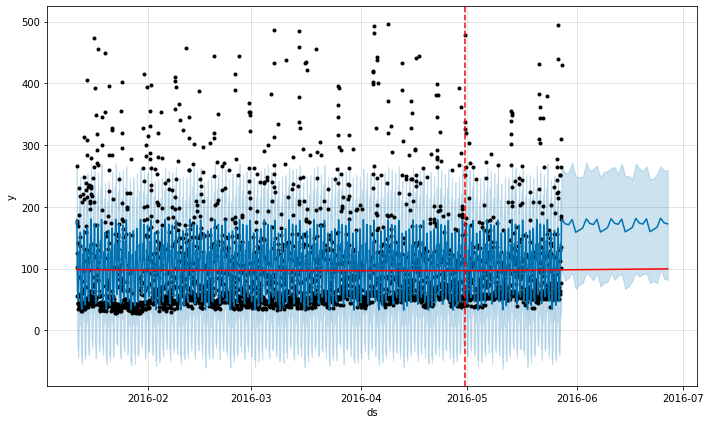

In [168]:
mod_map= Prophet(uncertainty_samples=1000)
mod_map.fit(df5)
future= mod_map.make_future_dataframe(periods=30)
forecast_map= mod_map.predict(future)

fig= mod_map.plot(forecast_map)
add_changepoints_to_plot(fig.gca(), mod_map, forecast_map)
plt.show()

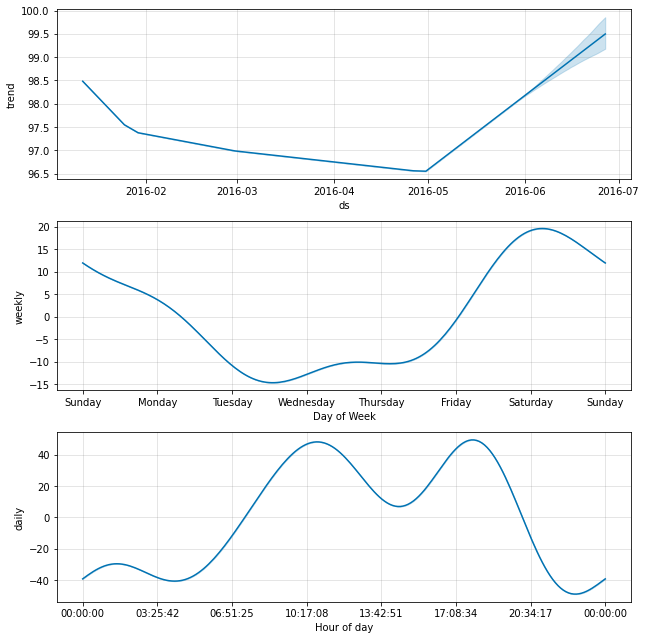

In [169]:
fig2= model.plot_components(forecast_map)
plt.show()

In [174]:
m0= mod_map
f0=forecast_map

In [170]:
samples = mod_map.predictive_samples(future)

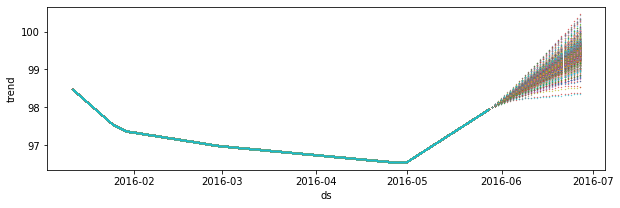

In [173]:
samples = mod_map.predictive_samples(future)

plt.figure(figsize=(10,3))
for idx in range (mod_map.uncertainty_samples):
    plt.scatter(future['ds'], samples['trend'][:,idx], s=.1, alpha=1)
plt.xlabel('ds')
plt.ylabel('trend')
plt.show()

In [ ]:
# modelling with  mcmc_samples Markov Chain 

15:23:40 - cmdstanpy - INFO - CmdStan installation C:\Users\benny\AppData\Roaming\Python\Python39\site-packages\prophet\stan_model\cmdstan-2.26.1 missing makefile, cannot get version.
15:23:40 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
15:23:40 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

15:25:52 - cmdstanpy - INFO - CmdStan done processing.
15:25:52 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to l

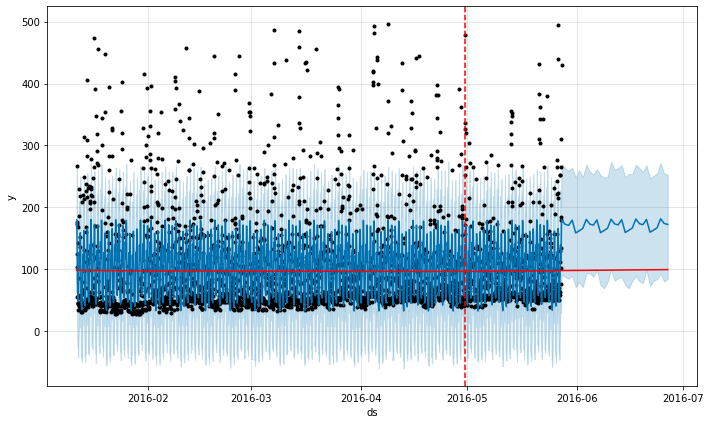

In [231]:
mod_m= Prophet(mcmc_samples=300)
mod_m.fit(df5)
future= mod_m.make_future_dataframe(periods=30)
forecast_mc= mod_map.predict(future)

fig= mod_m.plot(forecast_mc)
add_changepoints_to_plot(fig.gca(), mod_map, forecast_mc)
plt.show()

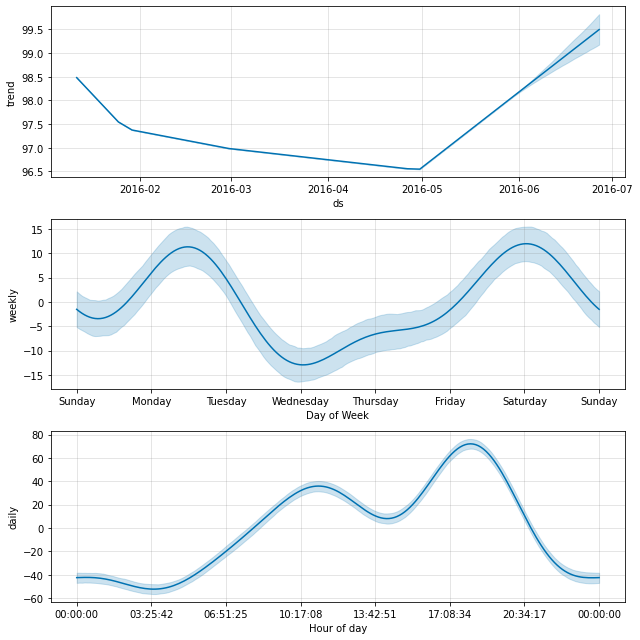

In [232]:
fig2= mod_m.plot_components(forecast_mc)
plt.show()

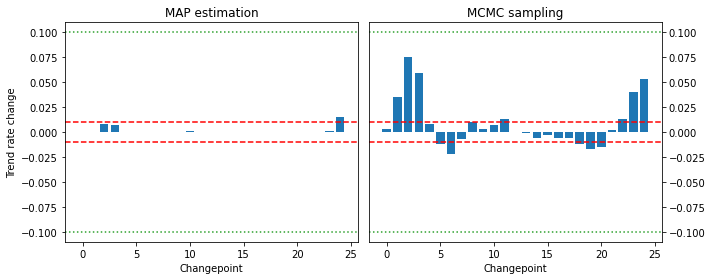

In [233]:
fig = plt.figure(figsize=(10, 4))

ax1 = fig.add_subplot(121)
ax1.bar(np.arange(25), np.nanmean(mod_map.params['delta'], axis=0))
ax1.set_title('MAP estimation')
ax1.set_xlabel('Changepoint')
ax1.set_ylabel('Trend rate change')
ax1.axhline(y=0.01, color='r', ls='--')
ax1.axhline(y=-0.01, color='r', ls='--')
ax1.axhline(y=0.1, color='tab:green', ls=':')
ax1.axhline(y=-0.1, color='tab:green', ls=':')

ax2 = fig.add_subplot(122)
ax2.bar(np.arange(25), np.nanmean(mod_m.params['delta'], axis=0))
ax2.set_xlabel('Changepoint')
ax2.axhline(y=0.01, color='r', ls='--')
ax2.axhline(y=-0.01, color='r', ls='--')
ax2.axhline(y=0.1, color='tab:green', ls=':')
ax2.axhline(y=-0.1, color='tab:green', ls=':')
ax2.set_title('MCMC sampling')
ax2.yaxis.tick_right()

ylim = max([abs(val) for val in ax1.get_ylim() + ax2.get_ylim()])
ax1.set_ylim(-ylim, ylim)
ax2.set_ylim(-ylim, ylim)

plt.tight_layout()
plt.show()

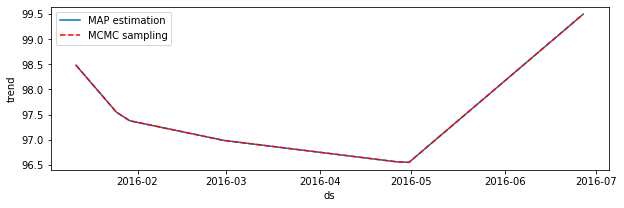

In [234]:
plt.figure(figsize=(10, 3))

plt.plot(f0['ds'], f0['trend'], color='#0072B2', label='MAP estimation')

plt.plot(forecast_mc['ds'], forecast_mc['trend'], color='r', ls='--', label='MCMC sampling')

plt.ylabel('trend')
plt.xlabel('ds')
plt.legend()
plt.show()

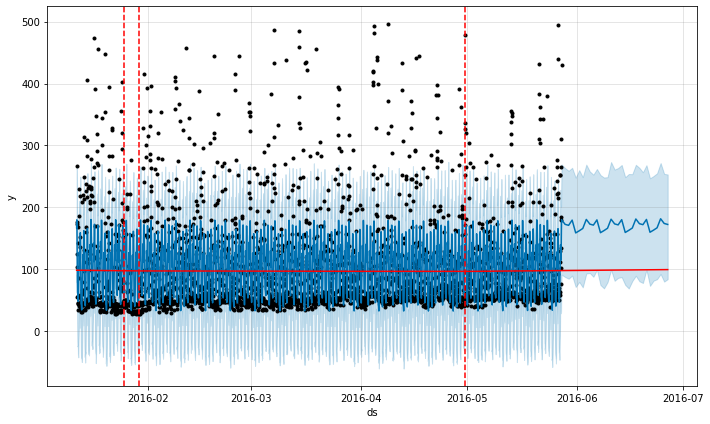

In [235]:
fig = mod_m.plot(forecast_mc)
add_changepoints_to_plot(fig.gca(), mod_m, forecast_mc, threshold=0.05)
plt.show()

#fig = model.plot(forecast_mc)
#add_changepoints_to_plot(fig.gca(), mod_m, forecast_mc, threshold=0.1)
#plt.show()
#threshold removes the number of chnagepoints
#0.05 is the default settings

In [186]:
# Saving for use later
m1 = mod_m
f1 = forecast_mc

12:44:23 - cmdstanpy - INFO - CmdStan installation C:\Users\benny\AppData\Roaming\Python\Python39\site-packages\prophet\stan_model\cmdstan-2.26.1 missing makefile, cannot get version.
12:44:23 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
12:44:23 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:45:33 - cmdstanpy - INFO - CmdStan done processing.
12:45:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Matrix of independent variables is inf, but must be finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, col

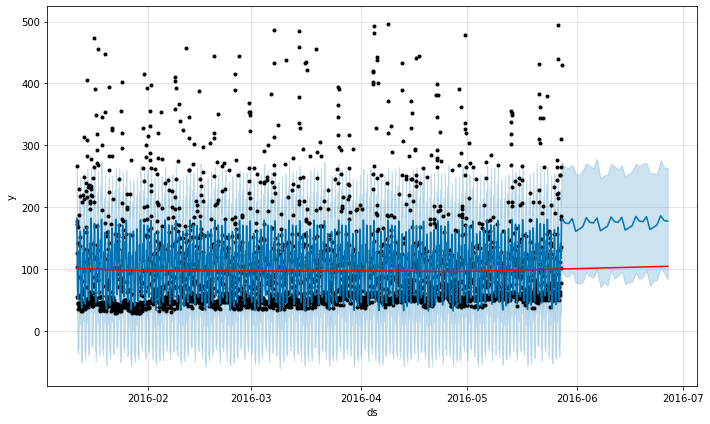

In [188]:
mod_ma = Prophet(changepoint_prior_scale=0.03,
                mcmc_samples=300)
mod_ma.fit(df5)
future = mod_ma.make_future_dataframe(periods=30)
forecast_mcm = mod_ma.predict(future)
fig = mod_ma.plot(forecast_mcm)
add_changepoints_to_plot(fig.gca(), mod_ma, forecast_mcm, threshold=0.05)
plt.show()

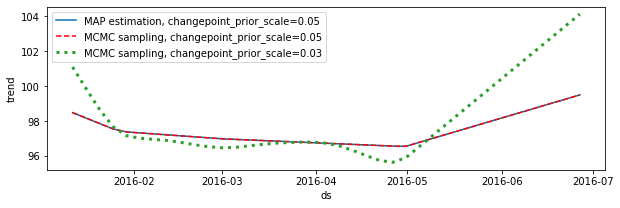

In [189]:
plt.figure(figsize=(10, 3))

plt.plot(f0['ds'],
         f0['trend'],
         color='#0072B2',
         label='MAP estimation, changepoint_prior_scale=0.05')

plt.plot(f1['ds'],
         f1['trend'],
         color='r',
         ls='--',
         label='MCMC sampling, changepoint_prior_scale=0.05')

plt.plot(forecast_mcm['ds'],
         forecast_mcm['trend'],
         color='tab:green',
         ls=':',
         lw=3,
         label='MCMC sampling, changepoint_prior_scale=0.03')

plt.ylabel('trend')
plt.xlabel('ds')
plt.legend()
plt.show()

In [190]:
dff_cv= cross_validation(mod_ma, horizon='30 days', period='30 days', initial='96 days')

  0%|          | 0/1 [00:00<?, ?it/s]

13:23:04 - cmdstanpy - INFO - CmdStan installation C:\Users\benny\AppData\Roaming\Python\Python39\site-packages\prophet\stan_model\cmdstan-2.26.1 missing makefile, cannot get version.
13:23:04 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
13:23:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:23:48 - cmdstanpy - INFO - CmdStan done processing.
13:23:48 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
Exception: normal_id_glm_lpdf: Scale vector is 0, but must be positive finite! (in 'D:/a/prophet/prophet/python/stan/prophet.stan', line 137, column 2 to line 142, column 4)
	Excep

In [122]:
df6 = ed_fm.copy().dropna()

df6['moving_average'] = df6.rolling(window=7,

                                    min_periods=1,

                                    center=True,

                                    on='ds')['y'].mean()

df6['std_dev'] = df6.rolling(window=7,

                             min_periods=1,

                             center=True,

                             on='ds')['y'].std()

df6['lower'] = df6['moving_average'] - 1.65 * \

               df6['std_dev']

df6['upper'] = df6['moving_average'] + 1.65 * \

               df6['std_dev']

df6 = df6[(df6['y'] < df6['upper']) & \

          (df6['y'] > df6['lower'])]


SyntaxError: invalid syntax (2108433174.py, line 20)